In [1]:
!pip install wordcloud
!pip install gensim
!pip install -U sentence-transformers

# Etapa 1: Modelagem de Sentenças

In [6]:
# MODEL = 'bert-base-cased'
# MODEL = 'dmis-lab/biobert-base-cased-v1.1'
# MODEL = 'fagner/envoy'
MODEL = 'biobert-nli'
# MODEL = 'bert-sts'

In [7]:
import os.path
import pandas as pd
from sentence_transformers import SentenceTransformer

DATASET = 'clicr'
DATASET_PATH = '../datasets/'+DATASET+'/cases-titles.txt'
# DATASET_PATH = '../datasets/'+DATASET+'/cases-narratives.txt'

sentences = []
with open(DATASET_PATH) as f:
    sentences = f.readlines()

OUTPUT_PATH = 'output/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
# OUTPUT_PATH += 'TopicAttention/'
# if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += DATASET + '/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += MODEL + '/'
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH, exist_ok=True)

In [8]:
MODEL_PATH = '../../models/' + MODEL
# model = SentenceTransformer(MODEL)
model = SentenceTransformer(MODEL_PATH)

embeddings = model.encode(sentences)

In [9]:
# TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_2/' + DATASET + '/' + MODEL + '/'

# embeddings_dataframe = pd.read_csv(TSV_INPUT_PATH + 'word_embeddings.tsv', sep='\t',header=None)
# embeddings_numpy = embeddings_dataframe.to_numpy()

# embeddings = embeddings_numpy[:, :-1]

In [10]:
# sentences_dataframe = pd.read_csv(FILE, sep='\t',header=None)
# sentences = sentences_dataframe.to_numpy()

<Figure size 640x480 with 0 Axes>

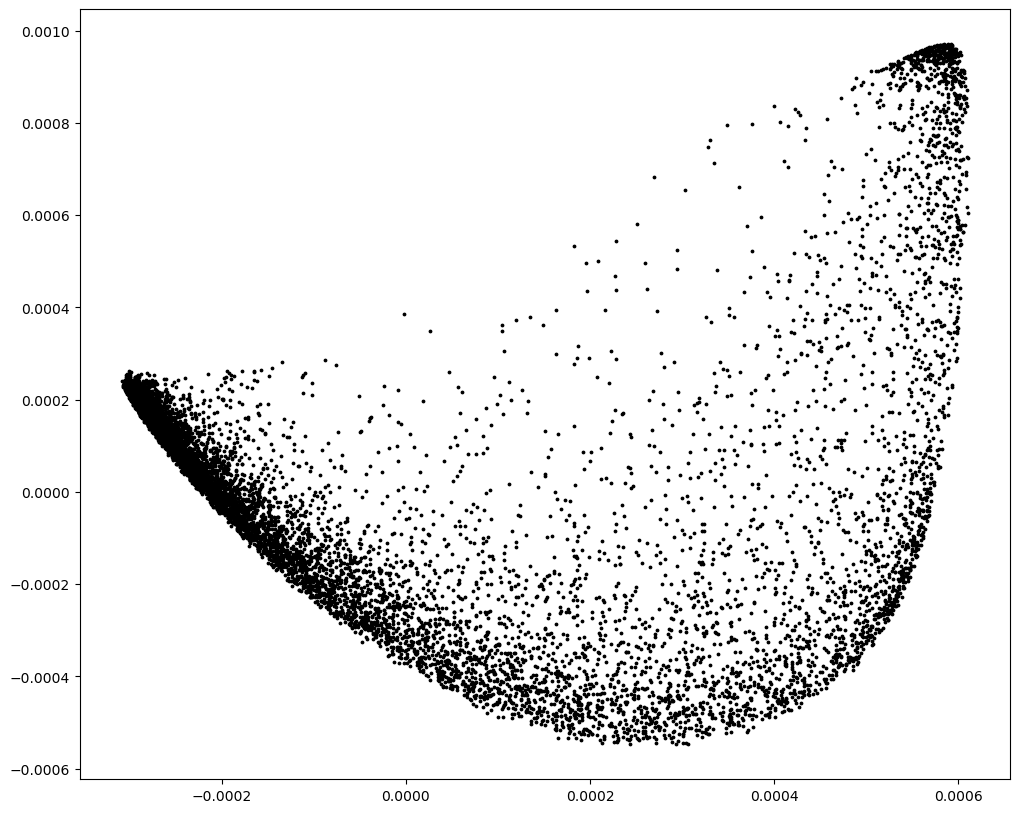

In [11]:
from matplotlib import pyplot as plt 
from sklearn import manifold

X_2d = manifold.SpectralEmbedding(n_components=2).fit_transform(embeddings)
 
x = X_2d[:,0]
y = X_2d[:,1]

plt.clf()
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black', s=3)
plt.savefig(OUTPUT_PATH + 'sentence-embeddings-'+str(MODEL).replace('/','').replace('.','') + '.jpg', bbox_inches='tight')
# plt.savefig(OUTPUT_PATH + 'sentence-embeddings-'+str(MODEL).replace('/','').replace('.','') + '.eps', bbox_inches='tight', format='eps')

# Etapa 2: Agrupamento de Sentenças

In [12]:
# DISTANCE_THRESHOLD = 10.5 # 100  80 62 60 55 48 44 40.25 40 17.85 15.5 11.83 11.32 10.5    bert-base-cased
# DISTANCE_THRESHOLD =  47 # 90 77 60 55 52 52.7 51.6 51 50 47 40   biobert
# DISTANCE_THRESHOLD =   400 # 460 400 300 220 180 156.5 150 130 120 110 36.5 envoy
DISTANCE_THRESHOLD =   125 # 300 iln-biobert
# DISTANCE_THRESHOLD =   175  #   150 130 120 96 95.6 sts-bert


In [13]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(linkage='ward', distance_threshold=DISTANCE_THRESHOLD, n_clusters=None)
clustering_model = clustering_model.fit(embeddings)

colors = [plt.cm.nipy_spectral(label / 10.) for label in clustering_model.labels_]
n_clusters = clustering_model.n_clusters_

print('Distance Threshold: ', DISTANCE_THRESHOLD)
print('Agrupamentos resultantes',  n_clusters)

Distance Threshold:  125
Agrupamentos resultantes 9


<Figure size 640x480 with 0 Axes>

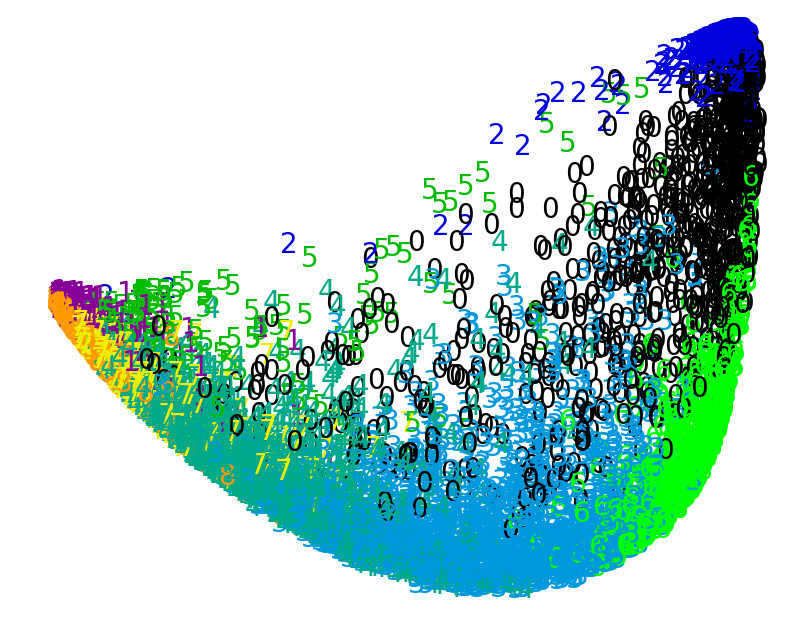

In [14]:
plt.clf()
plt.figure(figsize=(10, 8))

plt.scatter(x, y, color='w', s=1)
# plt.scatter(x, y, color=colors, s=1, cmap='hsv_r')

for i, sentence in enumerate(sentences):
    # plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color='gray', fontsize=18)
    plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=20)
    

if not os.path.exists(OUTPUT_PATH + str(n_clusters) + 'topics'): os.mkdir(OUTPUT_PATH + str(n_clusters) + 'topics')

plt.axis("off")
plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-'+str(MODEL).replace('/','').replace('.','') + '.eps', bbox_inches='tight', format='eps')
# plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-'+str(MODEL).replace('/','').replace('.','') + '.jpg', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

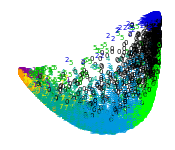

In [15]:
plt.clf()
plt.figure(figsize=(2, 1.7))

plt.scatter(x, y, color='w', s=1)

for i, sentence in enumerate(sentences):
    # plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color='gray', fontsize=18)
    plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=5)

plt.axis("off")
plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-mini-'+str(MODEL).replace('/','').replace('.','')+ '.png', bbox_inches='tight', transparent=True)


## Topic Hierarchy

<Figure size 640x480 with 0 Axes>

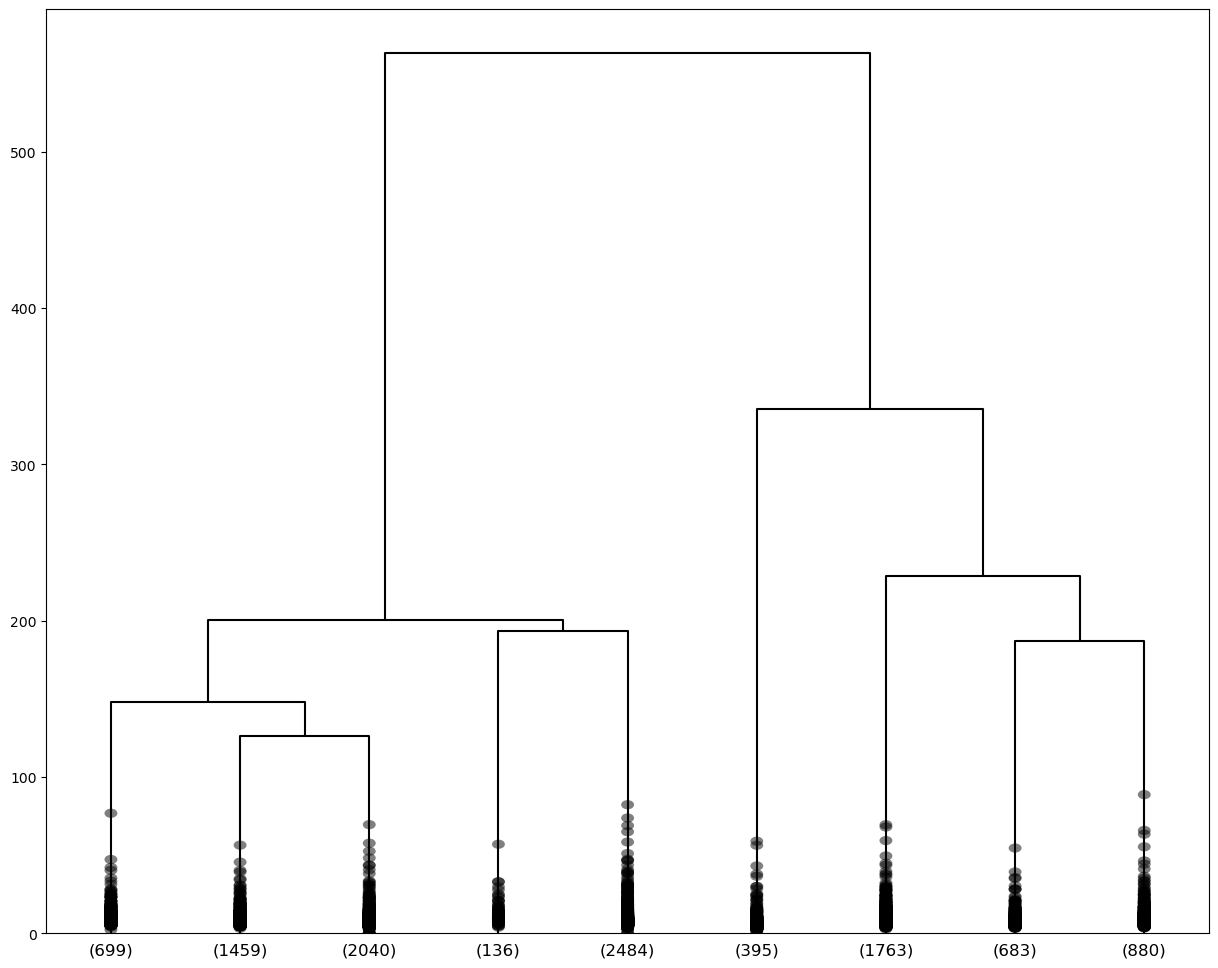

In [16]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np

plt.clf()
plt.figure(figsize=(15,12))

counts = np.zeros(clustering_model.children_.shape[0])
n_samples = len(clustering_model.labels_)

for i, merge in enumerate(clustering_model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else: current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clustering_model.children_, clustering_model.distances_, counts]).astype(float)

# r = dendrogram(linkage_matrix,  count_sort='ascending')data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA90AAAK7CAYAAADvFOx1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAACFaUlEQVR4nOzdd3xc9Z3v//d3NNKoW5Yt2bLcC7YBF7AxHUIJAUKABAjZbMpCdtm0mw3ZzW5y75a75e4vd++9m01PSHHY3ZACJKQ5ZOnFVJvihgvuRbJk9T4jzff3x5kZj6QZY2x9dWaOXs/Hww95zsxoPl+dMufzrcZaKwAAAAAAMPZCfgcAAAAAAEBQkXQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgSNjvACRp6tSpdu7cuX6HAQAAAADA27Zx48Zj1tqaTM/lRNI9d+5cbdiwwe8wAAAAAAB424wx+7M9R/dyAAAAAAAcIekGAAAAAMARkm4AAAAAABwh6QYAAAAAwBGSbgAAAAAAHCHpBgAAAADAEZJuAAAAAAAcIekGAAAAAMARkm4AAAAAABwh6QYAAAAAwBGSbgAAAAAAHCHpBgAAAADAEZJuAAAAAAAcIekGAAAAAMARkm4AAAAAABwh6QYAAAAAwBGSbgAAAAAAHCHpBgAAAADAEZJuAAAAAAAcIekGAAAAAMARkm4AAAAAABwh6QYAAAAAwBGSbgAAAAAAHCHpBgAAAADAEZJuAAAAAAAcIekGAAAAAMARkm4AAAAAABwh6QYAAAAAwJGw3wEAyC/33HOP7rvvPr/DAAAg0D74wQ/qrrvu8jsMAGOAlm4Ab8t9992n1157ze8wAAAIrNdee40KbiBAaOkG8LatXLlSTz75pN9hAAAQSO94xzv8DgHAGKKlGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHDkLZNuY8wPjDFNxpgtaduqjTGPGGN2JX5OTnvui8aYN40xO4wx73IVOAAAAAAAue5kWrp/KOnaEdu+IOkxa+0iSY8lHssYc6akD0g6K/GebxpjCsYsWgAAAAAA8shbJt3W2qcltY7YfJOkexP/v1fSzWnbf2KtHbDW7pX0pqQ1YxMqAAAAAAD55VTHdE+z1jZIUuJnbWJ7vaSDaa87lNg2ijHmLmPMBmPMhubm5lMMAwAAAACA3DXWE6mZDNtsphdaa++x1q621q6uqakZ4zAAAAAAAPDfqSbdR40xdZKU+NmU2H5I0qy0182UdOTUwwMAAAAAIH+datL9K0kfTfz/o5J+mbb9A8aYiDFmnqRFkl46vRABAAAAAMhP4bd6gTHmx5LeIWmqMeaQpL+T9CVJPzPGfEzSAUm3SZK1dqsx5meStkkalPQpa+2Qo9gBAAAAAMhpb5l0W2v/IMtTV2V5/f+S9L9OJygAAAAAAIJgrCdSAwAAAAAACSTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4EvY7AAAAALx99++8X+v2rPM7DDiwvXW7JOmOh+/wORKMtevnX6/bzrjN7zAwzki6AQAA8tC6Peu0o3WHFlcv9jsUjLHr/uU6v0OAAztad0gSSfcERNINAACQpxZXL9baa9f6HQaAk0DPhYmLMd0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4QtINAAAAAIAjJN0AAAAAADhC0g0AAAAAgCMk3QAAAAAAOELSDQAAAACAIyTdAAAAAAA4clpJtzHmbmPMVmPMFmPMj40xxcaYamPMI8aYXYmfk8cqWAAAAAAA8skpJ93GmHpJn5G02lp7tqQCSR+Q9AVJj1lrF0l6LPEYAAAAAIAJ53S7l4cllRhjwpJKJR2RdJOkexPP3yvp5tP8DAAAAAAA8tIpJ93W2sOS/q+kA5IaJHVYa/9L0jRrbUPiNQ2SajO93xhzlzFmgzFmQ3Nz86mGAQAAAABAzjqd7uWT5bVqz5M0Q1KZMeZDJ/t+a+091trV1trVNTU1pxoGAAAAAAA563S6l18taa+1ttlaG5P0c0kXSTpqjKmTpMTPptMPEwAAAACA/HM6SfcBSRcYY0qNMUbSVZLekPQrSR9NvOajkn55eiECAAAAAJCfwqf6Rmvti8aYByS9ImlQ0quS7pFULulnxpiPyUvMbxuLQAEAAAAAyDennHRLkrX27yT93YjNA/JavQEAAAAAmNBOd8kwAAAAAACQBUk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOhP0OAAG2Ya20+QG/o8BYa9zs/Vz7bn/jgBvLbpVW3+F3FAAAAIFB0g13Nj/gJWjTl/kdCcbQk391gd8hwJVkhQpJNwAAwJgh6YZb05dJd/zW7ygAnAx6LwAAAIw5xnQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4EjY7wAAAAAATEz377xf6/as8zuMcbG9dbsk6Y6H7/A5kvFz/fzrddsZt/kdhu9o6QYAAADgi3V71mlH6w6/wxgXS6qXaEn1Er/DGDc7WndMmAqVt3JaLd3GmCpJ35N0tiQr6U5JOyT9VNJcSfskvd9a23Y6nwMAAAAgmBZXL9baa9f6HQbG2ERq0X8rp9vS/RVJD1trl0haIekNSV+Q9Ji1dpGkxxKPAQAAAACYcE456TbGVEq6TNL3JclaG7XWtku6SdK9iZfdK+nm0wsRAAAAAID8dDot3fMlNUtaa4x51RjzPWNMmaRp1toGSUr8rM30ZmPMXcaYDcaYDc3NzacRBgAAAAAAuel0ku6wpHMlfctae46kHr2NruTW2nustauttatrampOIwwAAAAAAHLT6STdhyQdsta+mHj8gLwk/Kgxpk6SEj+bTi9EAAAAAADy0ynPXm6tbTTGHDTGLLbW7pB0laRtiX8flfSlxM9fjkmkAAAAAIC3xa+10P1alzwX1wY/rSXDJP03ST8yxhRJ2iPpDnmt5z8zxnxM0gFJuVViAAAAAJggkmuhL65ePK6f68ea5Mk13wOVdFtrX5O0OsNTV53O7wUAAAAAjI2JshZ6rq4NfrrrdAMAAAAAgCxIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwJOx3AAAAAGPl/p33a92edX6HMS62t26XJN3x8B0+RzI+rp9/vW474za/wwCAt42WbgAAEBjr9qzTjtYdfocxLpZUL9GS6iV+hzEudrTumDCVKQCCh5ZuAAAQKIurF2vttWv9DgNjaKK05gMIJlq6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcCTsdwAAACB47t95v9btWTfun7u9dbsk6Y6H7xj3z75+/vW67Yzbxv1zAQC5jZZuAAAw5tbtWacdrTvG/XOXVC/Rkuol4/65O1p3+FLJAADIfbR0AwAAJxZXL9baa9f6Hca48KNlHQCQH2jpBgAAAADAEZJuAAAAAAAcIekGAAAAAMARkm4AAAAAABwh6QYAAAAAwBGSbgAAAAAAHCHpBgAAAADAEZJuAAAAAAAcIekGAAAAAMARkm4AAAAAABwh6QYAAAAAwBGSbgAAAAAAHCHpBgAAAADAEZJuAAAAAAAcIekGAAAAAMARkm4AAAAAABwh6QYAAAAAwBGSbgAAAAAAHCHpBgAAAADAkdNOuo0xBcaYV40xv0k8rjbGPGKM2ZX4Ofn0wwQAAAAAIP+Ex+B3/JmkNyRVJh5/QdJj1tovGWO+kHj8V2PwOcGwYa20+QG/oxgfjZu8n2vf7W8c42XZrdLqO/yOAgAAAEAOOa2WbmPMTEnvlvS9tM03Sbo38f97Jd18Op8ROJsfkBo3+x3F+Ji+3Ps3ETRunjiVKQAAAABO2um2dP+bpL+UVJG2bZq1tkGSrLUNxpja0/yM4Jm+TLrjt35HgbE0UVrzJyJ6pwQXvVMAAMA4OOWWbmPMDZKarLUbT/H9dxljNhhjNjQ3N59qGADgFr1TgoneKQAAYJycTkv3xZJuNMZcL6lYUqUx5j8lHTXG1CVaueskNWV6s7X2Hkn3SNLq1avtacQBAG7ROyV4JkprPgAA8N0pt3Rba79orZ1prZ0r6QOSHrfWfkjSryR9NPGyj0r65WlHCQAAAABAHnKxTveXJL3TGLNL0jsTjwEAAAAAmHDGYskwWWuflPRk4v8tkq4ai98LAAAAAEA+c9HSDQAAAAAARNINAAAAAIAzY9K9HAAAABPD/Tvv17o968b1M7e3bpck3fHwHeP6uZJ0/fzrddsZt4375wIIDlq6AQAAcNLW7VmnHa07xvUzl1Qv0ZLqJeP6mZK0o3XHuFcwAAgeWroBAADwtiyuXqy11671Owzn/GhZBxA8tHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA4AhJNwAAAAAAjpB0AwAAAADgCEk3AAAAACCv7dmzRw0NDTp48KB+/etfq7+/3++QUki6AQAAAAB5q6mpST/60Y80MDCgoaEhbdy4UQ8++KDfYaWQdAMAAAAA8tYrr7yioaGhYdt27dql9vZ2fwIagaQbAAAAAJC3urq63tb28UbSDQAAAADIW/X19aO2FRUVadq0aT5EMxpJNwAAAAAgb5177rkqKytTX1+fenp61NjYqMsuu0xFRUV+hyZJCvsdAAAAAAAAp2pwcFDxeFyhkNemHIlE1NPT43NUx5F0AwD8tWGttPmB8f3Mxk3ez7XvHt/PlaRlt0qr7xj/zwUAIKA2btyovr4+RSZFJEmTJ0/WSy+9pEsvvVSlpaU+R0f3cgCA3zY/IDVuHt/PnL7c+zfeGjePfwUDAAABd/To0VHbhoaG1NLS4kM0o9HSDQDw3/Rl0h2/9TsK9/xoWQcAIOCmTJkyapsxRlVVVeMfTAa0dAMAAAAA8ta5556rSCQybNvy5ctVUVHhU0TDkXQDAAAAAPLW5MmTdeedd6qsrEyRSERXXnmlbrzxRr/DSqF7OQAAAAAgr02bNk01NTWSpMsuu8znaIajpRsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAAEdIugEAAAAAcISkGwAAAAAAR0i6AQAAAABwhKQbAAAAAABHSLoBAAAAAHCEpBsAAAAAkPei0ah6e3vV39/vdyjDkHQDAAAAAPKWtVYPPvigjhw5oqamJn35y1/W7t27/Q4rhaQbAAAAAJC3tmzZos2bN6ceDwwM6KGHHlI8HvcxquNIugEAAAAAeWvnzp2jtnV1damxsdGHaEYj6QYAAAAA5K1wOJxxe0FBwThHkhlJNwAAAAAgb5111lmjtk2dOlXTpk3zIZrRSLoBAAAAAHlr4cKFuuKKK2SMkeQl3LfddpvPUR2XuR0eAAAAAIA8cfnll2tWzywNDQ3pUzd8KpWA5wJaugEAAAAAea2xsVHHjh3TsWPH9PTTT2twcNDvkFJIugEAAAAAeautrU1r165Vb2+vBgYG9MQTT+hXv/qV32GlkHQDAAAAAPLWxo0bNTAwMGzb5s2b1dXV5VNEw5F0AwAAAADyVmtr66ht1lq1t7ePfzAZMJEagPywYa20+YHx/9zGTd7Pte8e389ddqu0+o7x/UwAAIA8NH36dG3btm3YtoKCAk2dOtWniIajpRtAftj8gNS4efw/d/py7994atzsTwUDAABAHjr33HNVUVEhSbKykqTzzz9fJSUlfoaVQks3gPwxfZl0x2/9jsK98W5VBwAAyGPl5eVas2aNHnz1QQ0ODiocDmvNmjV+h5VCSzcAAAAAIG8dPHhQjz/+uCJFEZWVlmlwcFAPPJA7vQZJugEAAAAAeev111+XtXbYtkOHDunYsWM+RTQcSTcAAAAAIG/19/e/re3jjaQbAAAAAJC35s2bN2pbSUmJpk+f7kM0o5F0AwAAAADy1ooVKzRnzpzU41AopOuuu07hcG7MG07SDQAAAADIW+FwWH/0R3+k2tpaVVdX69Of/rSWLx/nJV9PIDdSfwAAAAAATpExRqWlpZKk6upqn6MZjpZuAAAAAAAcIekGAAAAAOS1wcFBdXd3q729XQ0NDX6HMwxJNwAAAAAgb0WjUX3/+9/XsWPH1N7eru985zt6+eWX/Q4rhaQbAAAAAJC3XnvttVGt248++qhisZhPEQ1H0g0AAAAAyFv79+8ftW1gYECNjY0+RDMaSTcAAAAAIG+VlZW9re3jjaQbAAAAAJC3zjnnHIVCw1PbefPm5czSYSTdAAAAAIC8VVdXp9tuu02FhYUyxuiss87Srbfe6ndYKWG/AwAAAAAA4HQsXbpU9fvrJUm3XXubz9EMR0s3AAAAAACOkHQDAAAAAOAISTcAAAAAAI6QdAMAAAAA8tqhQ4d09OhRHT58WI888ohisZjfIaWQdAMAgDEVj8fV29urzs5Otba2+h0OACDgWlpadO+996qvr0+xWEzr16/XQw895HdYKSTdAABgzMRiMa1du1ZNTU1qbW3V1772NW3atMnvsAAAAfbKK6+ora1NPT096uru0r59+7RlyxZ1dnb6HZokkm4AADCGXnvtNR08eDD12Fqrhx9+WENDQz5GBQAIsoMHD+rVV19VLBbT0OCQ9u3bp+3bt6ujo8Pv0CSRdAMAgDG0d+/eUdt6e3vV2NjoQzQAgImgs7NzVOVuc3OziouLfYpoOJJuAAAwZkpKSt7WdgAATteUKVNkjFEsFlM0GlV7e7vq6+vV39/vd2iSSLoBAMAYWrFihYwxw7bNmTNH1dXVPkUEAAi66upqWWtljJExRoWFhRocHNTUqVP9Dk2SFPY7AGDMbVgrbX5gfD+zMTFJ0Np3j+/nStKyW6XVd4z/5wJABrNnz9ZNN92kZzY8o6HBIS1atEg33nij32EBAAIsHo+rqKhI4bCX3paVlaUS71xA0o3g2fyA1LhZmr5s/D5z+vLx+6x0jZu9nyTdAHLIypUrNatxlqy1+sPr/tDvcAAAAdfX16dVq1bpieInFI/HtWTJEk2bNk3t7e2qqKjwOzySbgTU9GXSHb/1Owr3/GhZB4CTNLKbOQAALkyfPl2RSESF4ULF43FNnjxZ4XA4Z7qXM6YbAAAAAJC3VqxYoZ07d6q7u1u9vb164YUXNH369JyZxJOkGwAAABihq6tL7e3tam1tVUNDg9/hADiBPXv2aM6cOYoUR1RYVKjFixertbV11DJifiHpBgAAANK0trbqW9/6ltrb29XZ2al77rlH27Zt8zssAFns3r1bkUhEJcUlKist0/Tp09XX15czFWYk3QAAAECa9evXq7e3N/XYWqtHH33Ux4gAnEgkEnlb28cbSTcAAABOmrXW7xCcO3z4sDo7O9Xb26uenh4dPXpUra2twxJxALlj2bLRqxbV1dWppqbGh2hGI+kGAADAW+rv79f999+v/Qf268CBA3r22Wf9DsmZwcFBvfrqq4pGo4rFYnrjjTd09OjRnGk1AzDc3Llzdf311ytU4KW3s2bN0vvf/36fozqOJcMAAADwln7zm99o69at0nQpbuN69NFHVVVVpbPPPtvv0MactXZUi/7g4CDL4AE5bM2aNZrVMkvxeFwfe/fH/A5nGFq6AeS81tZWtba16ljLMe3fv9/vcABgwhkYGNAbb7wxavtrr702/sGMg3A4rKVLl6qgoEChUEhz5szRjBkz1N/f73doAE7AGKOCggK/wxiFpBtATmtqatJ3vvMddXZ2qru7Wz/84Q+1adMmv8MCgAklFotpaGhI0Wg01eU6Ho8HNgmtqanRtGnTVFFRocrKSs2bN08VFRUqLi72OzQAeeiUk25jzCxjzBPGmDeMMVuNMX+W2F5tjHnEGLMr8XPy2IULYKJZv369BgYGUo+ttXriiScmxEQ+AJArysvLFQqF9MILL6QmF9u4caNmzJjhd2hOXHjhhaNayy6++GKFQrRXAXj7TufKMSjpz621SyVdIOlTxpgzJX1B0mPW2kWSHks8BoBTkml9xba2tmGJOABg/AW58rO+vl533nmnysrKVFJSoltuuUUXXnih32EBeAvRaFR9fX05d594ykm3tbbBWvtK4v9dkt6QVC/pJkn3Jl52r6SbTzNGABNYVVXVqG2lpaUqKioa/2AAYILq7u5WPB7X+eefr5LSEpWWlWr16tU6cuSI36E5U19fn+pmnmk5IgC5w1qrX/ziFzpy5IiOHj2qL3/5y9qzZ4/fYaWMSR8ZY8xcSedIelHSNGttg+Ql5pJqx+IzAExM559//qjZYtesWUMXPwA5o729XT09PYrFYn6H4kxhYaEKCgoUiUQUKYqoqLBIoVCIMc4AcsLWrVv1+uuvpx739/froYceUjwe9zGq4077rtUYUy7pQUmftdZ2vo333WWM2WCM2dDc3Hy6YQAIqAULFugDH/iAIpGICgsL9a53vUuXX36532EBgCTppZde0le/+lU1Nzfr8JHDeuyxx/wOyYlIJKIlS5aM2r5ixQofogGA4Xbu3Kne3l719vaqu7tbhw4dUkdHhxobG/0OTdJpJt3GmEJ5CfePrLU/T2w+aoypSzxfJ6kp03uttfdYa1dba1fX1NScThgAAm7x4sWqm16n+hn1uvDCC1knFUBO6Orq0sMPP3y8JcVKzzzzTMa5KILghhtu0NKlSyUjhUIhXXnllXS7BpAT+vr69MorrygajWpwcFBvvvmmdu7cmTM9I09n9nIj6fuS3rDW/mvaU7+S9NHE/z8q6ZenHh4AAEBu2r17d8aui7t27fIhGvdKSkp0++23a87sOZo1a5Yuu+wyv0MCAElSPB7X4ODgsG2dnZ2qqKjwKaLhTif1v1jShyVdaYx5LfHveklfkvROY8wuSe9MPAYAAAiUwsLCjNvD4fA4RzK+jDETpsdRPB7X0NCQ32EAeAuRSEQ1NTWKxWKKRqPq6enRGWecoZaWFr9DkySd8reCtfZZSdmuuFed6u8FAADIBwsXLlRxcbF6eno0NDSkUCikgoICnXnmmX6HhtNkrdXDDz+sgwcPylqrf//3f9ctt9yisrIyv0MDkEFRUZFaWloULgxL1lvp5siRI5oyZYrfoUkao9nLAQAAJppIJKJVq1bp1VdfVVdXl7q6u3TGGWdkXOoQ+WXDhg168cUXU2uR79mzR7/97W99jgrAiRQUFMjIpHrjhMPhnOmpQtINAMA4iMVi6unpUU9vz6hxZ8hP/f39eumll7Rq1SpVVlaqsqJS27dvz5nujDh1W7ZsGbVtx44dgV4WDshn0WhU5557rooiRQoXhrVo0SItXLhQHR0dfocmiaQbAADnWltb9bWvfU3Nx5rV3Nysr3/96zlzI4BTt2vXLsViMRljUjPkWmu1fft2nyPD6cqUXA8NDeVMqxmA4erq6lRSUqLSklKVl5Wrvr5ehYWFypVVski6AQBw7JFHHlFnZ2fqcXt7e2DXc5akQ4cO6ejRo6l1q4Pasp/sejxSphnNkV8WLlyogYEB9ff3q6+vT11dXZo1a5aKi4v9Dg14W1544QUdPnxYhw8f1osvvuh3OM6sWrVKkyZNGrbtwgsvzJlzlqQbAADHdu/efVLbguDYsWO699571dfXp1g0pmeeeUa//GUwVw9dsGCBCgoKRm1fvHixD9FgLC1dulQ7d+5Uf3+/BgYGtHnzZi1cuNDvsIC35aWXXtLDDz+sWCymWCym3/3ud9qwYYPfYTlRWlqqP/mTP1FVVZXKy8v1/ve/X1ddlTtze5N0AwDgWFFR0UltC4KNGzeO6pq7ZcsWdXV1+RSRO2VlZbrxxhtTS4cZY3T11VertrbW58hwujZs2KCzzz5b5eXlKisr0/nnn6/XX3/d77CAt+Wll146qW1B0dvb61UwDMbU2tqaU8NBgr2QJAAAOWD58uV67rnnRm0Lovb29lHbrLXq6OhQRUXF+Afk2IoVK7Ro0SJt/v1mFRUV6ZJLLvE7JIyBw4cPp2Y/lrxZkVtbW9Xb26vS0lKfo3Pj/p33a92edeP+udtbvTkQ7nj4jnH/7OvnX6/bzrht3D93vKQPazrRtiBob2/XD37wA/VU9UiSHn30UbW0tOimm27yOTIPLd0AADh25ZVXasWKFanH55xzji677DIfI3Knrq5u1LZcmszGhdLSUpWUlGTsao78VFlZOWpbJBJRJBLxIZrxsW7POu1o3THun7ukeomWVC8Z98/d0brDl0qG8VRfX39S24Jg48aN6u3tVTQWVf9Av7q7u/X666+ru7vb79Ak0dINAIBz4XBY733vexVvvUeSNDdHat5dWLVq1agxgxdddFGgkxUEz3nnnaedO3cO27Zq1arAV6wsrl6stdeu9TuMceFHy/p4u+KKK3Tw4MHU48LCQr3jHe/wLyCHjh49qldffVW9F/dK8oaInHHGGWpra1N5ebnP0dHSDQDAuAmFQqmlpYKqrKxMd911V2oym9tvv11XXHGF32EBb8uiRYt0yy23qKioSOFwWJdffrmuvvpqv8MC3pbZs2frE5/4hMrLy1VeXq6Pf/zjmjVrlt9hOdHR0aGGhobUqgONjY3atWtXxl4rfgj2Nz8AABh35eXlqqys1KRJk7Rkyfh3GwXGwrJlyzRjxgzNnDlTV1xxReArzBA8AwMDevjhh9Xd3a3u7m79/ve/VzQa9TssJwYGBtTW1pZayrG/v1+9vb05M4Z94nYv37BW2vzA+H9u4ybv59p3j+/nLrtVWh38bjQAAP899dRTOnjwoKy1+ta3vqXbbrst0GO6ASAXPf7449q1a5c03Xu8c+dOPf7447r22mv9DcyBtrY21dTUqN22y1qr4uJiFRcXa2BgwO/QJE3klu7ND0iNm8f/c6cv9/6Np8bN/lQwAAAmnF27dumJJ55ItTY0NTXpgQf4DkL+aW1tVWtrq44dO6a9e/f6HQ7wtm3duvWktgVBdXW1du7cqcHBQQ0ODurAgQNqbW1VcXGx36FJmsgt3ZI0fZl0x2/9jsK98W5VB4CT1N3dLfV0KxwOKze+FnG6tmzZos7OTvVU9Cgej2vv3r2Kx+Nqbm6mtRt5o7m5Wd/73vfUOdnrmnrvvffq5ptv1sqVK/0NDHgbMq1THY/HfYjEvb179yoWi6UqfCVvcrVcmERNmsgt3QDyxsDAgLq6utTR2aGOjg6/w8EY2bZtm/7t3/5Nx44dU2Njo372s58N+7JEfmpvb9drr72mWCymoaEh7d+/Xzt27NDg4KDfoTnz5ptvqr29Xb29vRzDAbF+/fpR3VKffPJJ9i/yyhlnnHFS24Jg3759o+ZdCIVCevnll32KaDiSbgA5rbOzU9/85jfV0tqitrY2fe1rX9OePXv8DgunaXBwUL/+9a+HJWLbtm0LbLe3iaS/v39US0pHR0fOtDaMtXXr1uk//uM/1NrWqqamJv30pz8lMQuAhoYGNTc3q6u7S51dndq3b5/a2trU19fnd2jASXvnO9+p2tra1ONp06bpqquu8jEid4aGhmSMUSgUkjFG4XBYsVhMpaWlfocmiaQbARS3cVlxwxMUzz777LDW7cHBQf3Xf/2XjxFhLBw5ciTjzeubb77pQzQYS1VVVcO6kRcUFGjx4sWB7KVy7NgxPfLII3rppZfU2dGpzs5OPfvss4z/DYCBgQFt3bpVQ4NDig/FtW/fPh0+fDhnxocCJ6O8vFyf+MQnNH36dE2fPl0f//jHA1sBmmzBT1Z6WmtVUlKi+fPn+xlWCkk3AuPw4cP61re+pQMHDujw4cO0hgbE/v37R21rbGxUf3+/D9FgrBQWFmbcXlRUNM6RYKzNmDFDixcvVlFRkQoKCrRkyRLV1tZq6tSpfoc25nbv3q3NmzenKpDi8bi2bdumbdu2+RwZXDDG0IsBeSfZ6ltYWChjjN/hOLNixQpNmjQp9TgUCumss87KOK7dDyTdCIRYLKYf/ehHOnr0qCSvNfQnP/mJN0kT8lqmbkFFRUVZkzbkh7q6uoxJ2Nlnn+1DNBhLZ511lrZu3apoNKqhoSFt3bpVFRUVgWwhbGlpGTVWPTlpXBANDQ3p8ccf16FDh3Sk4UigKxeKi4u1bNkyhcNhFRQUaMGCBZoxY0bOLD8EnIxoNKof//jHOnTokA4ePKif/OQngV2ne2hoSHPmzFFpaalKSkp05plnSvJmNc8FJN0IhJ07d6q3t3fYtmg0Gugbgoni3HPPHbVt+fLlKigo8CEajKXbb79d06d7i4eGTEjXXXedZs+e7XNU7mzatEkHDh7QgYMHAn1t2r59u5YsWaLi4mIVFRXpzDPPVHd3dyBv9KZNmzaqMiEcDmvGjBk+ReTWb3/7W91zzz061nJMx5qP6ctf/nJge5XNmDFjWKu2tVbV1dUqKSnxMSrg7Xn88ce1Y8eO1OPt27frySef9C8gh0pLS1VdXa1QQUgFBQWKRCJasGCBWlpa/A5NEkk3AiJbV2O6IOe/ZcuW6V3vepc3MYaMVq9erXe9611+h+XcRJiXoKamRh//+Mc1c+ZMzZw1U+eff77fITmzfv16feELX0it+/v5z38+Z2ZUHWuHDx9WJBJRcXGxSktLVVtbq2g0qqamJr9DG3OLFi3S8uXLNXny5FQXzuXLlweyx0YsFtNPf/pTNTY2StZr0d+1a5ceeughv0Nzor6+PjXr/uDgoPbs2aPy8vJAd89F8GzZsuWktgVBVVWVJk2apPhQXIODgwqFQiorK1NFRYXfoUki6UZAzJ8/P+MXYa5MnoDTc+GFF2r2rNmaM2eObrjhhkB3Ld+zZ48OHzms/fv3a+3atTp27JjfITkXLggrZIL9dXTvvfcO643T09Oje++918eI3KmsrJQkxQZj6u/vVywWkzEmtT1IKisrddNNN2nlypWaNGmSysvLdc0116i+vt7v0MZcZ2enjhw5Mmp7UHtt7NixQ9XV1amku7i4WEeOHAnsGscIpqGhIR05ckRdXV3q6upSQ0NDYJdvrKys1MaNGxWNRhWLxfTmm29qz549qqqq8js0SSTdCIjJkyfr0ksvHbZt1apVmjlzpk8RAW9fR0eHfvzjHysWi0nyJpH70Y9+xE1eAGSazTqoM1yfc845euKJJ9RyrEXt7e26//77FQqFApl0S9LFF1+sT37yk6qurlZdXZ2uvfZav0NyorCwMONEh7myHM9Ye/311/XGG29ocHAwtd78K6+8Qg865JVQKKSdO3dqaGhIQ0ND2rFjR2CH5z333HPq7u5WPB6XtVb9/f06cOCAGhoa/A5NEkk3AuTKK6/Un/7pn6q6ulrTp0/Xe97zHr9DAt6WLVu2pBLupLa2tsAmZxNJpoQzqEnoCy+8oP7+/tRaqZFIRBs3bgzsrM8HDx7Ufffdp+bmZjU1NWnnzp1+h+REZWWlzjnnnGHbCgsLdcUVV/gUkVv79u1TZ2dn6nFfX5/27duncDjsY1TA29fV1aX+/n719/cHeoLhV199VZK3TGVBQYFKS0t17NgxHThwwOfIPCTdCJS6ujpVVlSqOBK8WXIRfCMnA3yr7cgfI+chMMYEtkV0/fr1KikpUVFRkSKRiKZMmaL29nZt3rzZ79DGXCwW01e/+lX95je/UVdXl1pbW/Vv//Zvw5K1IPnYxz6m1atXp8bsX3311brmmmv8DsuZaDSa6l7e29urgoICZi9HXtm+fbvKy8tVVFSkoqIilZWVafv27X6H5URhYWGqRX9wcFB9fX0KhUIKhXIj3c2NKAC8bY2NjWpra1NHZ0dqjVjkt7lz547aZozRnDlzxj8YjKkPf/jDOvPMMxWLxRSLxbRs2TJ94AMf8DssJ4wxisfjisViikaj6unpkaScufEZS1u2bNFLL72khoYGRaNRRaNRbdq0Sc8//7zfoTmxaNEi/fVf/7VmzJihmTNn6u6771ZZWZnfYTlRVFSk/v5+WWtlrVU0GlU8Hg/0nCIInp6eHhljUsmnMSawFfkrV65MLeM4NDSklpYWxeNxLVy40O/QJJF0A3lpy5Yt+s53vqOOzg61tbXpW9/6lrq6uvwOC6dp4cKFWrJkybBtl112WWC7IU8kL7/8smpra1VdXa0pU6aourpar7zyit9hObFmzRrt2LFDAwMDikaj2rVrl/r7+3XWWWf5HdqY27Vrl44cOZIaRzg0NKSGhga98cYbfofmTHKG4GTrWVAlJwBM/xeLxUi6kVfmzJkzbKLhUCikWbNm+RiROyO7kRtj1N3dnTNDQki6gTxjrdUjjzwybHxkZ2dnYFtWJO9C2tTcpMajjdq0aZPf4ThjjNHtt9+u2tpaVVVV6Y//+I8DO14y6Y033tCxlmNq72gPdI+N9BlVk/82btzod1hOdHR0DJtcKxwOB7pb7sh5GJJdG5HfjDGqrq5OjQ+tqqpSRUVFYIcOIJhWrVqlVatWKRKJKBKJaNWqVVq9erXfYTmxZcuWYRPPWms1ODiop556yseojiPpRqDEYjENRAcUt8Gd7bmzs1MdHR2jtufKRBFj7eDBg6nllvr7+/Xzn/880BUMxhgVFxerrLRMM2bM8Dscpx599FH99Kc/VXd3t9rb2/W9730vsDMDHz16VC+99JL6+/vV19enF198MZDrVkvS5s2bNWfOHJWWlaqkpERLly5VYWFhINeGra+vV0VFhXp6elJjCYuLi7VgwQK/Q8Npqq2tVWVlZaqVu7y8XFVVVYHtTo9guvrqq1VXV6eSkhKVlJSorq5OV111ld9hOdHc3DyqwrOnpydnVlgg6UZgbN++XV/+8pfV0NCggwcPpmYxDJqSkpKMXWUqKip8iMa9559/XkNDQ8O2Pffcc4GdCfnVV1/VoYOHdPjIYX3lK1/Rvn37/A7Jid7eXj3//POy1mpoaEjxeFwtLS167bXX/A7NiY6OjmE3A4ODgxkrz4IgORwiZEKpVkJJqq6u9jMsJ+bOnavKykqVlJQoFPLKW1FRofnz5/sdmjPJ9X6TFQ1BtXLlSrW2tioejysej6u9vV319fWB7lKP4KmurtYll1zizU0gq0suuUSTJ0/2OywnRibX1loZY+heDoylvr4+Pfjgg6nJIay1+vWvf622tjafIxt7RUVFWr58earbTPKmJ6jdhY4dOzZqW1dXVyC7qjY3N+tXv/qVhuJDstaqo6NDP/vZz0Z1Xw2Co0ePqr29XS+++KK6urrU2dmp/fv368iRI36H5sSkSZOGrY0aDoc1adIkHyNy54Ybbhg2hlDy5isIYiLa29ururo6zZkzJ9V9s66uTtFo1O/QnNi7d6+++tWvqqWlRc3Nzfr2t78d2GEhfX19stamxuonv3OCXNGA4Nm4caN+97vfeT02ZLRu3brAzicyffr0YXMuJHuo5Mo8DCTdCISdO3eOSkzi8Xhgl0VYs2aNmpqa1NPTo56eHlVUVGjevHl+h+VETU3NqG2VlZWKRCI+ROPWtm3b1NzcrK6uLnV0dGjDhg1qamrSnj17/A5tzE2aNElbt24d1p187969gb2BnzZtms4//3wVFxerpKREa9asUW1trd9hObFmzRp98pOfVDgcljFGZ599tv7xH//R77Cc6Orq0plnnqnFixerqKhIJSUlWrFiRWrG9qBZt27dsO/a5uZmPffccz5G5M7jjz+uwcHB1MzP4XBYL7/8ciArfBFcL7zwQmrN+WTl9gsvvOB3WE7Mnz9fxcXFqZnaS0pKVFpaqkWLFvkdmiSSbgREsovqwYMH1dPTo/7+fg0ODg6bUCFIfvOb36Ru6owx2rNnj15++WWfo3LjoosuGtU16JJLLhnVkhYE7e3t2rZtW+q47e7u1ubNmwN5k9fX1zdqbGR6V+SgOffcc1VUVKTi4mJFIhEVFRXp3HPP9TssZ2677TadffbZWrZsmb7+9a+rrq7O75CcmDVrltra2rR//34NDg5qYGBATU1NgZwduLu7W83NzaO2792714do3GtoaFB3d3dqybCenh61tLQEsucRgmvTpk3at29fapjE3r17tXnzZr/DcmLRokUKh8Opc3ZwcFAzZ87Mmcp8ku6A27lzp440HNGBgwf061//OpA375LXdXHbtm3avXu3YrGY+vv79frrrwdyMpuenh49/vjjOnDgQKqyYevWrXr66af9Ds2J+vp63XnnnSorK1NJSYluv/12rVmzxu+wnMhUURSLxQK5vnE8HtfSpUs1c+bMVCvSihUrVFJS4ndoTlx66aVauXJlahmt1atX68ILL/Q7LGd6e3vV3t6utrY27dy50+9wnKmoqFB7e3sqEbPWqqWlRVVVVf4G5kBhYaEKCgrU1dWlvv4+9Q/0KxqNqri42O/QnAiFQqm1uePxuAYGBmStDeT1GMHV3d19UtuC4MCBA6nz01qrgoICHTt2jInU4F5DQ4P+8z//U52dnerp6dFjjz2mX/ziF36H5URbW5umTp067MuwpqZG7e3t/gXlSDQaVWNjY2qsWTJJC+qEW5I0Y8YM1Uyt0bTaaVq6dKnf4TgzadKkYS1kxpic6RY11urr6zVp0iQtXLhQlZWVKi8vV2VlpRYvXux3aE40NjZq27ZtqVbuLVu2BHb28t7eXt1zzz1qb29XV1eX7rvvvsBWCu7atUvz5s1TaWlpqivykiVLAjm0KRKJqKysTBs3btRA/4D6+/q1YcOGQFZuS1550yfsTN7EB7U3DoKprq5O7e3tGhgY0MDAgNrb2wO7MsrevXvV1taWOm/7+/vV3Nys/fv3+xyZh6Q7wJ5//nm9/PLL6u/v18DAgF577TU99thj6urq8ju0MXf06FHV1dXpggsuUGlpqSorKzV79mwdPXrU79DGXCgUUiQS0eHDhxWNRhWNRtXc3JyaMTiIBgYG1NnlLZUWxIqUpHnz5mnBggWqqKhQaWmpLrjgAtXX12vu3Ll+hzbmQqGQ3vve9w4bm3/uuecGNul+7LHHhk2u1d/fryeeeMLHiNzZuHHjqPP0mWeeCWRPq3g8rscff1xbt27V4OCg+vr69PDDDwdyne5kz6qysrLUJJ61tbWBvSYnK8iSQ5kKCwsViUQCObQJwZUc15ysMCotLQ1s75QdO3aklvhLzsXQ39+fM9coku4A27Rp06hxDHv37lVra6tPEblTXV2tzs5OvfTSS6nJIlpbWwO5RE1yErGBgYHUurCxWCywkzJ1dnbqG9/4hlpaWtTa1qqvf/3rgZxYTPImAVm2bJkKCgpUVFSkSCSiK6+8UuXl5X6H5sTChQt19913q7a2VjNmzNCNN94Y2BvaTDXtBw4c8CES9zLNQB+LxTKOB8530WhU+/fvV1tbm2KxmAYHB3XkyJFAlrW7u1u7d+9WT0+PwuGwCgoKdPToUe3YscPv0JwoKSlRcXFx6ua9uLhYpaWljOkOgGg0qv/6r//S4cOHdfToUR0+fNjvkJwpLCxMLTUbDodVUlKSM7N5j7VwOKx4PD5sTHcoFFJnZ6ffoUki6UZA1NfXa8OGDXrzzTc1ODio/v5+Pf/885o5c6bfoY253t5exePx1OyMoVAoNd4siJ555hlt2bJFnZ1eS/eWLVu0bt06v8NywhijW265RdXV1SopLtEHP/hBXXLJJX6H5VRRUdGE6LJZXl6ugwcPpioFDx06NGoiuaCYNGmSrLXe/BoDXk8rY0wgl0jbtm2burq61N/fnxry093dHchENBKJjKooisVigV3mr7KyctgN/NDQkCKRSGDnnZhIfvGLX+i5555TLBZTX1+f7r333kA2SEle0r1mzRoVFxeruLhYa9asyZl1q8dabW3tsF5GyWvyWWed5WNUx5F0B9jy5ctHfTnMmzcvkK2/GzdulORNamOMUUFBgSKRiNavX+9zZGNvcHBQvb29mjFjhsLhsAoLC1VXVxfYG5/nnntOe/bsSY3RaWxs1Pr164ctNRUkv/nNb3T06FG1tbfpu9/9bmBnpZekw4cP6ytf+YoaGhp08ODBwHa3lqTi4mLt3r07NQ/Dm2++mTOTu4y1lStX6umnn1Zra6va29r1i1/8QuFwWBUVFX6HNuaam5sVjUaH9dCIxWI6dOiQj1G50d/fn3GCuCBWpkjeagoju6oGtSfORNLe3j5qzoVoNBrYtatnzZqlQ4cOpcZ0Hzp0SLNnz/Y7LCcyzVI+NDSUM8N9SLoD7KKLLtJ5552nkpISRSIRnXPOObr66qsDeeOzZ8+e1KzlyZqtWCwW2KVMSktLFYlEVFhYmOrmF9QuyJnG5R87diyQM8ju27dPP/jBD9TR0aHOzk49/vjj+uY3v6ne3l6/Qxtz1lrdf//96ujoSG176qmntHv3bh+jcmdgYEAzZ85MDQmZNWtWzixjMtZefPFF9fX1pZKVwsJCbdiwQUNDQ36HNuayXYeC2H2ztLRUZ555pmbNmqVQKKSCggItXbo0sJM9DgwMaNq0aSooKFAoFNLUqVMViUQCW+E7UXR0dAybIC8pV8b9jrXy8nK9+eabqaR79+7dgb1fPHjw4KiKMWttzlSoBO+uFSnTp0/Xhz/8YVVUVKi8rFxXXXWVbr75Zr/DcmL27NlqamoatmxLU1OTpk+f7nNkY6+8vFwrV64cNhFGTU1NYJfRyrQPa2pqArkG+xNPPKEtW7aklg5raWnRSy+9pC1btvgd2pg7cuRIaqmlaDSaqonetm2bz5G50dDQoMbGxtSQkMbGRjU2NvodlhPJnijJbrn9/f06evSo3njjDb9DG3MzZsxI3cAmb+RLS0sDObQpHA5r9erVmjZtmoqKilRUVKTq6mqdd955fofmRGVlpTo6OjQ0NKR4PK6Ojo5URTfyV21tbcbhTEGd0fv5558flYg+//zzPkXjVm9v76gKlaGhoZzpVUbSHXCLFi3SjLoZmjVrlm644YZhMwUHSWVl5ahubxUVFaqpqfEnIIcKCgp0zTXXpMbolJWV6ZxzztFFF13kd2hOXHzxxVq4cKEk76a2rq5Ol1xySSBn39y6deuwGa4lb132Xbt2+RSRO8lKhWeffVZdXV3q7OzUG2+8EcjKFElqaWlRQ0NDqrWhoaEhsGMIW1tb1d7enrr5CeokapLXlT69G7Lkzc2watUqnyNzo76+Xi0tLYrGoorGvMqyIA5Zk7zvm2PHjqWGhLS3t6u9vZ0x3XmupKRk1P3S5MmTdc455/gUkVubNm1SY2Nj6jhubGzUpk2b/A7LiUxDXZK9rXIBSTcCYWhoSJdffrkWLFigcDis4uJiveMd7whkF2RJWrJkSap1MDlz+ZQpU/wOy4kLLrhAjY2NqWRl3759ga1gyPSFUVBQEMjl4KZPn67XX39d+/fvT7V2b968ObDnbHt7u3p6elI3Pj09PWpra/M7LCemTZs2althYWEgK0E7Ojo0adKkYbNcT5o0Sd3d3X6HNuastXrsscc0Z84clZeVq7ysXCUlJYFtNcvU66a5uVk9PT0+RIOxdNVVV+n2229XeXm5qqqq9Cd/8ieBrUxpa2tTT09PamhTb29vYL97ss25MHny5HGOJLNg3t1gwpk/f74mTZqkSy65RFOmTNGkSZNUXV2tBQsW+B2aE7/85S9VXFys8vJylZaW6tChQ9qwYYPfYTmxbt06tbe3p1qSrLX6yU9+4ndYTlxyySXDln4rLCzUzJkztXz5ch+jcuPgwYMaGhpSKBRKdUMuKCgI7DwM3d3dw8oaCoUCmZhJ0ooVKzR79uzUjM8FBQW6+OKLA9mLoaGhQZI3UV5y6EBBQUEglyDq7u7WkSNH9Nvf/lZNTU1qamrSCy+8ENil7xobG1VYWJiaQC0Siainp0ddXV1+h4YxsHTpUk2dOlVVVVU50/3YlWg0mvruSa4mEUSZKsSstRnnBvIDSXfAdXR0qLW1VU3NTYHtTiJ5tViXX365BgYGFIvFFI/HtXr1atXX1/sd2pjr6enRwYMHR20P4nhJSfrd736nhoYGDQ4OamhoSA0NDXr22WcDOZnNBRdcoCuvvDI1+eGSJUt00003ac6cOX6HNuaOHTsmyRsnaq2VMUZFRUVqamryOTI3otGoBgYGht34jBxKEBRz585NTRJnjFE8HtfQ0FAg59iIRCLq7u5O7dt4PK6urq5ALoFXXFysJ598Urt37071stq4cWNg52FIroYiadikgEFP0BAsFRUVqqioSFUKJh8HUbZeKOkTtvqJpDvAurq6dM8996ijs0M9PT36+c9/rscee8zvsJwJh8Patm2bOjo61N3dPeEmOwlqzeW+ffvU1taW6pbb0dGhw4cPBzJhKSkp0ec//3nV1NSovLxcH/7wh/Xxj3/c77CcmDlzptrb21Pry1tr1dLSkjPdwMZasnzJLn7JSocg2rlzpxobG1NlbWtr086dOwN5zhYVFY269hpjAjnnRF9fnxoaGob1WIjFYoFNuq+88spURcrQ0JCi0ajOOuuswHZDRjDNmTNn2HxOkUhkQi0ZJnnX6VxA0h1gL7/8snbt2qXOzk51dHRo06ZNeuqppwLZQtjZ2alPf/rTeuyxx9TX16eOjk595jOfCeTa1WVlZaqvr9frr7+upqYmHTt2TEeOHNHSpUv9Ds2J5Eze6WKxWM5cRMfafffdp6amJvX09Oj73/++Hn30Ub9DciJ97GvypjYUCgVy3K+ktC64RpLXarZv3z4fI3Ln97///aibn/3792vr1q0+ReRONBodNedCRUVFxiWJ8l1ra6tCoZAikUiq5be0tDSwY5xra2tT3XIl73unpKQkZyZlwqkbHBzUk08+qSMNR9Tc3BzYlSQkqbq6OjU0T/IqBadOnepzVG4kK/FHevPNN8c5kswmZNK9a9cuHW06qqbmpsCOH5SkLVu2pGZDjkaj2r9/v15//fVAzpj7i1/8Qjt27EhbB9bq4MGD+sEPfuBrXK7s379fTz/9tKLRqPr7+/Xwww8HdgKq2bNnD0uwQ6GQ6urqArnm7yuvvKIHH3ww9XhgYEBf+9rXcqZr1Fjq6+tLLTlUUFCgcDisqqoqdXZ2+h2aE729vYlWUckYb7x+UJOVQ4cOpSbuSU4a19nZGcgx7FOmTFF/f7+i0aji8bisterr6wtkj43a2lpVVFSopKREBQUFKigoUFFRUSCXR5OkH//4x8N6ZwwNDWn9+vVZb+yRPx566CE9+eSTig5E1dPTo7Vr1wZ2ne6Ojg7FYrHUevODg4OBnUgt27mZK/s2mHfpJ7Blyxb96Ec/Ul9fn3p7e/Xv//7vgVyOR/LWwW1oaEjd+LS0tAS2ZeXRRx9NtZYlx0zG43E988wzfoc25gYGBvTQQw+pvLw8NWlPKBTS1772Nb9Dc2L58uXDxoJOnTpVixcvDmT3zSeeeEKSUhNQDQ0NKRaL6emnn/Y5MjfC4bDq6+tVXFysSCSiysrKQFamSF7rZ/r1aWhoKJCz0iel3/wMDg6qv78/kOMIBwcHdfjw4dT6sMkleYKYmJWWluo973nPsAkBy8vLdeedd/odmhO7du0a1WOhs7Mz0K2iE0FnZ+eoXjcDAwN65ZVXfIrIrcbGRpWVlaWG6JWVleXMxGJjLVsPo1ypZJhwSffIJMxaq2effdanaNxKdotKnmjJWvgg3gzU1NSkypc0NDQUyNaGPXv2qL29Xc3Nzamlltrb23Om+8xYmzt37rA1Jpubm1VZWRnIiYpCoZDa2trU19en/v5+7d27Vz09PYHsxVBUVKRFixYpFoulhhBMnjxZ8+bN8zs0J6ZNmzZsmEQ8HteMGTN8jMid3t7eUduC+t3zxBNPjCpXLBbTL3/5S58icusDH/iAFi5cqHA4rMLCQq1Zs0aXXnqp32E5MTg4OOyeIlnREIvFfIwKp6utrS1jchbEXqCSN79TsgFuaGhIR44cmXAz8OdKZX7w7uTeQnNz80ltC4LKysrUjM+Dg0Pq6uoK7Hikd73rXSooKEh9KVrrrW985ZVX+h3amJs+fbra2tqGdXvr7u4ObFfVxx57bNgFMx6Pa+PGjTlzER1LZ555pg4cOJA6b1taWnTw4EGtWbPG79DG3IwZMxSNRrVr1y719/err69PBw4c0Jlnnul3aE5UVVWNaumuqqryOywnBgcHh1UUJcf/trS0+BiVG7/73e8ybn/uuefGOZLx8fzzz+vCCy/U5MmTNXnyZM2ePVsvvfSS32E5kaliNx6Pa9asWT5Eg7FSU1OTcd8GcXUFSal5ndInow3ikLUTyZUVByZc0p1pkp6gTtwTCoXU19cnY4xCIW8Shfb29kC2/lZXV6u+vl4FBQWJGzxvv86fP9/v0Mbc4OBgahme45UMNpAT90hKJdjJG3fJG9MexC+NXbt2Deu6GY/HZYzRzp07/Q5tzMViMT3//POp41mSDh8+rBdffNHnyNx44YUXhrWQxWKxwPayKi4uHtVCKAXzuzbbjOxBnKm9u7tbhw4d0ssvv6zW1la1tbVp9+7d2r17t9+hOZFtJuQgrzwwEZSWluq8884btq2yslLnnnuuTxG5tXfv3mGNFENDQ9qzZ4+PEbmTrVdgrvQWzI0oxtEll1yi5uZmdXd3q7u7W62trbr44ov9DsuJlpaWUWvzRSIRNTQ0+B3amItGo5o0aVJqWYRQKKTq6uqM3RzzXXNz86jeCrlyQXEhGo2qr68vVUvb29uraDQayCXhtm3bpsHBQUmStV6rSjQa1aZNm3yObOw9/vjj6u3tTV2jCgoKVFxcrN/85jd+h+ZEpq6LQb15Ly8vH7XiQDweD+QY9rPPPjvj9iBOLlZYWKhnn31Wzz//vAYGBlKTeAb1Bj55LR6pqalpnCPBWHvXu96lc845R/F4XOFwWB/60IdypjV0rGVqoMiVicXGWrZVbebMmTPOkWQW3Dv1LJItZpISLcChUTcHQVFYWKi6urrURFtTpkzR5MmTA1kDb63Vm2++qb6+vlSysnv37kCWdd68eaPKFdRjWPJazUZ2y5VyZ93FsRSNRtXd3Z1oGbQaHBxUR0dHIHunJMdyd3Z2amgorsHBIfX19QVy2ICUeYKXoJ63+/fvH7VtaGgokBNQTZs2LeP2IHZBttZqx44d6unpSU1c2tXVpZdfftnv0JzI1nssyJXcE8WTTz6pV199NTWb909+8pNALqcrZT6Og9ozMltFWa5Ugk64K8f69es1depUlZeXq6ysTFVVVYEde7Vq1aphE0Z0dHSouLhYixYt8jmysbd+/Xr19/cnbti95Cwajeqpp57yO7Qx19LSknE8UhBbfiVvXfJ0xhiVlJQEMmHJNMFLcvK4oLnqqqtSS97F40OpXgzLly/3OzQnMp2fQZxfQ1LGmXGttdq2bZsP0biV7F01UrJyP0gOHTqkrq6uYTe2sVgssEuvZlshI6gTIB4+fFiNjY06cOCAfvzjH+fMjM9jra+vT+vXrx+2rbW1Va+++qpPEbmVqZIoiBPRStmT7p///OfjHElmEy7pzjSRSxAnd5G89Y1LS0s1ODioWGxQsVhMs2fPDmRytnv37lEzig4ODgay21tynO/I5CyoM6p2dnYOS7Cttert7Q1k0p2t22KmlsN819raqkmTJikWiw2bkyBby2G+y5ScBXHZOyn7WqlB7HmUbZmhkUsSBUFxcXHGfRjUmZCnTJkyals4HB5VERwEPT09+t73vqe2tjZ1dnbq97//vX74wx8G9ns2U3J2+PBhH6JxL1PlblArfLPJlXuoCZd019bWpsYi9ff3KxqNqra21u+wnNi6dav6+/tTE4sZY9TQ0BDI9fmytQQGsYWwpKRk1AQv8Xg8sEl3W1vbsFYjY0wglx6SsneZnzRp0jhH4t7hw4fV3t6eqIX3rlHW2sBOpJZpUqagrjiQ65PZjKVskxwGce6UWCyWWiUkyVobyCRUynzOWmuzTrCWz1577TW98MILGhgY0ODgoPbt26enn35a+/bt8zu0MZft+zSoq0lkGrKVrUU4qHJlOGLwvgHfwhlnnKH169erq6tLXV1deu6557R06VK/w3Li5Zdf1uHDhzU05HXdbGlp0aZNmwKZsGS7gARxfGhyLOxIQZ2USdKo9Y0lbybdoJk5c+aobl+FhYUZW1zyXUdHh7q6uhI9N7xtAwMDge2qmumcDWpFWbYJiYJYwZ2tIiGIYyZra2sztpAFsVJQyjwB1dDQUCAnodqyZcuoyoTk7PRBU1VVpcWLFw/bVlhYGNjZyzN9zwT1uyebXGnZn3BJ98aNGxWNRlPdGaPRqDZs2OB3WE7s3r172MQQ8XhcbW1tgfzCmEh2796d8YYuqF38MlWcxOPxQNZKL1u2bNTwj6KiIi1btsyniNxJrzRJP5yDOpnNRFJRUZFxe11d3ThH4l62sZFBbNXv7u4e1d04yMtVZqu0D2LDRba5CYI6BOZ973ufLrjgAoULwyopKdFHPvIRVVdX+x0WHOns7PQ7BEkTMOlev369IpGIwuGwwuGwCgsL9cwzz/gdlhPJL4bkUkvJ9XCDODlGtlqsII5fz/blGMRWfSnzTW1Qu/iVl5dnvIEN4lImlZWVKiwsTNzEezfuxphAtoZONNkqTjK1HOa7bGUN4vj1oaGhjOUN6ljYbA4ePOh3CGNu+fLlmjx5cmqFkMHBQdXX12v+/Pl+h+ZELBbTsWPH1N/Xr4GBgUD2nDuRIE70eCK5MnHchEu6u7u7deTIEUWjUUWjUTU0NAR2XF1FRcWwL/7khTSIN7XZEs4gdqHJVtYgtqxImW/Uo9FoIMu7adOmUd2Qo9GotmzZ4lNE7ixZsiS1FFzS4OCgFi5c6GNUGAvZWhUOHTo0zpG4N5HGrx87dizjxFpBvYfKJlvFdz47++yzNW3aNMXjcVlrFYvFtGjRItXX1/sdmhPf+MY39MMf/lDd3d1qbW3VP/7jPwZyHgYp87UoiNenE8mVMewT668ur6tmS0tLKulubW0N5AVUUmLN6uGtZkNDQ4Gc9CRbC0oQbwayVZoEtaW7t7c34/Yg1kzv2LFj1H6MxWKBbFlpbm4eVVZjTNaJqZA/snW/DWIvq4k0n4iUeaz6RLuBD+LQpqNHj6q6ulqlpaUqLi7W0qVLZa0N5D1UU1OTHnvssWHn7pEjR/SrX/3Kx6jcmUhLzGaTKxMCTqwrpbzlwbzJe6zicavOzs5A3ghImWfuHhwc1GuvvTb+wTiWLQEL4hfG9u3bM24P6k1etiVLgph0NzY2jtpmrdWBAwd8iMat559/ftQxG4/HAzuR2kSSrYdRtgq0fJZthYwgzk0wa9asjDfrlZWVPkTjnyB2zd21a5eKiopUUlKi8vJyzZ07V8aYQC67unfv3mFzOyUFcdI4KXOlWBCP4ROhpdsnBw4cUCgUSiyh5R14b775pt9hOZHpBj4ej6u8vNyHaNzKttZ6EBOzIM9Snkm2L4cgjnPO1kIYxPHrkydPzlhRFMRzFp4gftdmuz4FcX3j3t7ejJNNLVmyxIdo/JMra/6OpfR5cZJdzEduD4rp06draGhIR44c0cDAgAYGBtTR0aFp06b5HZoTme4rglgpeCK5Uskw4ZLu3t7exAXFmzE3Ho8HsjVUyt7yuWPHjnGOxL1sLStBbP0N6vIs2WSbACOIs6pmu1HPlTUmx1K25DqI8zDAE8QbvWzXoVy5yRtLdXV1GXsGBrW3YDZB7Jp71llnaffu3WpqalJTU5N+/vOfq62tTQsWLPA7tDE3a9YsFRQUqK2tTbFYTLFYTO3t7VqxYoXfoTmRaUhIUFccyIaJ1HxSUFCQ6GZgJVkNDg4G8gIqZW4JNMZo8uTJPkTjVrZx+UEca3bkyBG/QxhX2boFBbElKVsFYFNT0zhH4l624zhXlvbA2AtiJWi2JTiDeFN76NChjJVimzdv9iEa/wSxErSrq0u7du1KHbd9fX3aunVrIL9njx49qp6eHnV2dioej2toaEhdXV0T7t5qIsmVyvzgZSRvIdMNfBCX9pC8LjQjWWt15ZVX+hCNW9lOqCDe+GRbA3eiyTakIJ9lG/Pa2to6zpG4l23/BfV6jGC2dE+k4/Wpp57KuD1XxkuOl1xpNRtL69atS90vJZdv7O3t1ZNPPulvYA4cPXpUb7zxxrAKhc7OTj300EP+BQWncqXyaMIl3ZmSs1ypARlr2cb+BnF24GzJda6caGMpiMtHnYqjR4/6HcKYyzamO4jrG2frYRTEijJ4gjqUa6II4vjeU5Fpvpx819LSogMHDigWi2loaEjHjh3ToUOHAvnds3XrVvX39w/reTM4OJh1klrkv2z3VuNtwiXd0vCxVsaYwN7kZeuS+swzz4xzJO5NpDHdQZwB+FQEcem7bMdxENc3zjYWNqjXYzBJXr4L4nAteMLh8LAJO6216urq0tSpU32Myo1oNDqqQcZaG8ieOMgtE+4KWlxcPOymzlobyJt3KftELkFMRLNdLIPY7S3bEjUTzUT6ggzi7OXZKhKC2DsFniD2TplI6KngCeKyq4WFhaOWfps6dWogW7qzTUZLpRJcm3BH2OTJk4edWKFQKOMSGEGQ7cJyzTXXjHMk7mW7UQ9iq9lESjZPZCIlZ0EcQ5itpXsi7deJJtukY8gPfPd4grgCTF1dnWbMmKFwOJyacLe2tlYzZszwO7QxF41GMybYE229eYy/CZd0h8NhFRUVyRgjY4wikUhgxyllSziDmIhmu1EPYqt+bW2t3yHkhMOHD/sdwrgJYtKdrRdKEK9P8NCSlN+oEPMEcT3nNWvW6NixY6kx3U1NTerr69OyZcv8Dm3MLVy4MOO94URbjhXjb8J9A45MsK21gVz+Qco++dKjjz46zpG4N5FmkH3jjTf8DiEnBPW8zSSI3ct37dqVcTtJd3CxbxEEU6ZM8TuEMbdr1y41NjYqHo/LWquBgQEdOHAgkPOJZFuWsqGhYZwjwUQz4ZJuafREakGVrSUpiDfw2VoCg7h/g7hm86mYSEl3EHtscIMz8QRxjo2JpLy83O8QcsLWrVv9DmHMrV27dtREnl1dXfr1r3/tU0TuPPLIIxm3B7GCAbkl85otARbEJCybgoKCjN3BZs+e7UM0bk2kMd10gfIEcZ3uiSSow3qQXRCvxxMJE+F5jhw54ncIY+7IkSPDegwODQ3JWqvdu3f7GJUb2VaACerywcgdE66lOxqNJiaKCMmYkMLhcGC7Jk+ePDnj9iAm3ROpBSWIPRVOBV+Q+Y3jeOIh6c5ve/fu9TuEnBDE755M91DxeFxVVVXjH4xj2cbkM2cBXJtwSXdpaakKCgpkjGSM1xpcWlrqd1hOZLqwhMPhQLaUBnGiqWwmUgXDiRw8eNDvEHAaGCYB5JeJNHnliQTxuyfbOOcDBw6McyTuZZt9nkpBuDbhku7a2tphM6gWFBSorq7Ox4jcOeecc1RaWpqaqb2oqEg1NTWBXBahvr4+4/YgVqhkW2ppomG98vwWxNYiIMiCuGbzqWhtbfU7hDGXbd6QIK7Nnu0eKohzpyC3TLiku7q6WpMmTVI4HE61+gZ1ne7rr79eixcvVjgcVkFBgerr67Vq1SqdeeaZfoc25rJNqhXEBDWIwwNORRB7bEwk9NgA8ksQx/fCk63L9UUXXTTOkbi3Z88ev0PABDXhJlKrq6vTzJkzVVjo1d7NmjUrkGsuStItt9yiF154QWX2qKy1OuOMM/SXf/mXgVwrNVu3oCBOnNfV1eV3CDmB8VcAMH7onRJc2Wbu3rBhwzhH4t7mzZv9DgET1IRLumfPnu2N4w4dlDFG5513nmbOnOl3WE6Ew2F9+ctfVtfXNioajeqn//DTwLYOzp07N+O6v7W1tT5E4xazPnvoCgYA4yeok84i+4zsL7300jhH4l622csB14LX5PkWVq9erfLycpWWlqqkpERlZWVavXq132E5VVFeoSnVUwKbcEvSGWeckXH7vHnzxjkS9+he7gnieH0AyFXt7e1+hwBHsvViCGLvBiqP4JcJ19J9ySWXKB6Pq+Dpn0uSrrnqGp133nk+R4XTlW18aBC7ly9btszvEHICLd0AALgTxJ51JN3wy4RLuo0xuvzyy6U9syRJswI4ScREVFZWplAoNGycrzFG5eXlPkblxvnnn+93CDmByjIAAE5ftjlSsi0lls9YGgx+mXDdyxFMS5YsUVFRkcLhsKTjS6QtXrzY79DG3Ny5czOuS56ti31QVVVV+R0CAACBxfhnYOyQdCMQFi9erDlz5igSiSgUMjImpPr6ep177rl+hzbmampq9I53vEORSCS1rbKyUp/4xCd8jGr8VVRU+B0CAACBFcTegoBfSLoRCGeffbYuu+wyrVixQqWlpSovL9Nll10WyKQ7FArpn//5n3XNNdckylquP/zDP9RHP/pRv0MbV9XV1X6HMG6YNA4A4Eq2Suy5c+eObyBAgJF0IxCqq6v1/ve/X5dddpkmTZqkqqoq3XzzzZo1a5bfoTmxZs0affWrX9X8+fO1YMECfelLX9LkyZP9DsuJ4uLiUduMMYFMujOVVZLOOuuscY4EADBRnHnmmRm3X3rppeMcCRBcJN0IjKuvvlqf+tSnVFtbqxl1M3TTTTf5HZJTc+fO1dQpUzW5arIqKyv9DseZTDXtZWVlgZxV9d3vfnfG7Z/85CfHORL3WPoOQD7KVjmaz7JNTHrJJZeMcyTuBXH/IT+QdCNQZs6cqUmVk7ioBog3Tv/4pcoYo8LCwkB2ub777rtH9ViYNWuWbrjhBp8icieIkxyeyKRJk0ZtmzJlig+R+GeilTdo+F71vPOd7/Q7hDFXVVU17DvVGKNJkyZpYGDAx6jcuPHGG/0OARMUSTeAnFZQUKDi4mIZ481KH4lEVFxcrI6ODr9DG3MXXnihPvvZz6qiokKlpaW65JJL9E//9E+aOnWq36GNuWyz7adPEBgk//2//3eVlZWlHpeXl+tv//ZvfYxo/F199dV+hzDm0isEg+62227zO4SccPvtt/sdwpgrKyvT1KlTVVhYqHA4rGnTpmny5MnDrllB8T//5//MuH2irQCD8Tdxvi0A5KXKykpNnTpV4XBY4XBYU6dOVXl5uYqKivwObcyFQiH99V//tc444wzNmztPP/jBD/SRj3zE77CceP/7359xe1DHr9999936m7/5G1VVVamqqkp///d/r09/+tN+h+WEt3TjaMuWLRvnSNzLNm9IECuPPvzhD/sdQk5YsWKF3yGMuXPPPVdTpkxRKBRKVXTX19drwYIFfoc25iKRyKjzNhwO62Mf+5hPEWGiIOkGkNOuueYahcNhFRQUpP6de+65gV3KJBQKqaK8QjU1NVq0aJHf4Thz1llnacGCBTLGpLaVlpbqz//8z32Myp3CwkL91V/9lZYvX64Vy1foc5/7XGBbSbPdqF955ZXjHIl72Vp/gzgWdvr06Rm3FxQUjHMk4yNbxUkQh0msXLlSV111lcrKyhSJRHTOOefo6quv1sKFC/0ObcyVlpbq+uuv1/nnn69IJJJ6HNSW7kzDQoI4PO9ErrvuOr9DkETSDSDH/dmf/ZmuuOKKVEv32WefrX/6p3/yOyycpilTpujzn/+8rr76akUiEZWXl+vOO+/UNddc43doToVMaFhFQxC9853vHFXGysrKQI7jX7p0acbKk4suusiHaNyaM2dOxqWlgrg0p+SVa+RxXFNTE8iJS2tra3XbbbepclKlJk+erAsuuEAf/OAHA9ljY/r06Vq2bJkuu+wyTZ48WVVVVVq5cqVWrlzpd2hO1NbWDrtGhUIh1dTU+BiRO9m+Wy+77LJxjiQzkm4AOa20tFTf+973tGTxEi1auEgPPfRQIGvfJ6IPf/jD+uQnP6n6+nrNmDFDd999dyDHr080VVVVmjZtmkIhr4KhrKxM8+bNU1tbm9+hjbkpU6aovLx82E1tWVlZIFtDKysrdfPNN6uqqio1x8a0adP02c9+1u/QnPjQhz6k+vp6FRQUpBKV66+/PrCthGvWrNGsmbNUV1enu+++O7Atv5I3vGn+/PmKRCKKRCK67rrrArsmeXKIXigUSh3HmSb2DIJs9w+5sqRu5oFXAJBjUt3Js4wXRf4pLS3VzTffLLV919swf76v8WBshMNhnXHGGWotbZWNWy1fvlwlJSWBbeEvLCxUeXl5qpt1UVFRYMv6jW98Q6WlpXqu7DmFQiH92X//M/3BH/yB32E58b73vU/79u3TY5WPKW7juvLmK3XXXXcFdt9KXitoJBIJ5JKc6WpqavTxj39c63+zXgUFBbrgggv8DsmZFStWaP369al9WlpaquXLl/sclRtLly5Vc3PzsG2FhYU5U15augEAwJg555xzVFJSonBBWIWFhSoqKtKcOXMC2aWxv79f8+fPV1lZmYwxCoVCmjdvXmATs4qKCn3729/WihUrtGLFCn3mM58JbFmnT5+uv/iLv1B9fb3qZ9TrL/7iL7R69Wq/w8IYCofDgT1+kz75yU9q7ty5CheGFS4Ma86cOfrUpz7ld1hOXHPNNcPGsBcUFKimpiZnhg6QdAMAgDFz0UUX6YILLlBxSbEikYiWL1+u66+/PuN44Hy3evVqlZeX64wzzlBZWZlKS0tVUVER+OQsHA4HdiLAdLW1tZoyZYpqamoC3d0awXXRRRfpH/7hH1RWVqbysnL9wz/8Q2Bb9ufPn69Fixallr6bMWOGzjvvvJxZYjb4V0wAADBupk6dqo997GOaXDVZlZWVuvHGG3XTTTf5HZYTCxYs0HXXXZdaJs0Yo4svvlhr1qzxOTIAkHbv3q0nnnhCJcUlKi4u1hNPPKE9e/b4HZYTkUhEq1atUlFRkcLhsObNm6fFixcrHo/7HZokxnQDAIAxNmvWLE2bNk2SdPXVV/scjVuf+9znvNaknf+gkuIS/e37/jawy2gByC9PPfXUsKQzHo/r6aef1vwAzqFSVlamvXv3Krw4nBo6sGfPnqzLHY43WroB5IVoLKr+gX5Za/0OBThlA9EBDUQH/A4DY6igoEALFixQuCCs4uLiQC6zNJHFYjENDAzw3YO81NjYeFLbgmBgYEDTp09XPB7X4NCgjDGaMWOGWlpa/A5NksOk2xhzrTFmhzHmTWPMF1x9DoBgGxwc1H333acjR46osbFR3/jGNwK59BCCraenR9/97nfV0NCghoYGff/731dfX5/fYWEM/Ou//qsuvfRS7dmzR5s2bdIXv/hFv0PCGBgcHNSPf/xjHT58WA0NDfr617/Odw/yTqblsnJlCa2xFo1G1djYqGg0qlg0pkOHDqmnp0cDA7lR0e0k6TbGFEj6hqTrJJ0p6Q+MMWe6+CwAwfbcc89p586dqcfHjh3Tb3/7Wx8jAt6+Rx99VIcPH049PnjwoJ544gkfI8JYOHDggL7xjW8oFotJkqy1+slPfqL169f7HBlO1wsvvKAdO3akHre0tOg3v/mNjxEBb9+FF144altQJ1I7fPiw9u3bJ8mbXyMWi+mFF15IDXXym6uW7jWS3rTW7rHWRiX9RFIwZ1EB4NT27dtHbdu9e7ei0agP0QCn5o033jipbcgv999/v4aGhoZts9bqwQcf9CkijJVM3z179uzJmVYz4GSsXLlS73vf+xSJRBQpjuiWW27RihUr/A7LiUOHDqmkpCT12BijkpISbd261ceojjMuxqgYY26VdK219o8Tjz8s6Xxr7afTXnOXpLsSDxdL2jHqFwEAAAAAkPvmWGtrMj3havbyTCvND8vurbX3SLrH0ecDAAAAAOA7V93LD0malfZ4pqQjjj4LAAAAAICc5CrpflnSImPMPGNMkaQPSPqVo88CAAAAACAnOelebq0dNMZ8WtLvJRVI+oG1NjdGsQMAAAAAME6cTKQGAAAAAADcdS8HAAAAAGDCI+kGAAAAAMARku40xlNkjLnK71hcm0hlBQAAGC/GmGJjzIeMMXP9juV0cb+IiWA8ztkJn3QbYwoSP431BrjXSvqKMeaPjTGF/kY3dhIXzVDy/0Eu68kwxsw3xnzHGPNBv2NxIbmvE/8PdFkl75hO+3/gy5tEWYNjop2z6YJe3hH7dkGQy5ou6Ps1Kf3+Ksla2y9pqaR7jDFn+xPZqUmUpyD5mPvFiXEcSxOnrH6dsxM+6bbWDiX+G0o8PiTpDyS9X9Kn/IprrFlPPPn/xM9Dkj6ogJV1pJEnliRZa/dI+p2ku4wx7x7/qMZe+kUkua8T/w9cWUeyaTNCBrW8E+U4liZmWTOcsw8rYGWVJs6+zXQ9NsaErbW75a3sEsiyJh9LwdyvmSTvr4wxBcaY840xlYnt/0PSa5L+zhizwNcgT0JiP5pEeYYS25JlCfz9YqZETArmcTyRypqJX+fshE+6jTHXG2NaJd2VeBy21m6W9C1JdxpjVvka4GlKfvkZYxYZY9YaY35ijLnRGFMiSdbaTQpIWbNJnFjTjDG3GmOmp21/SNK9kv7SGLPEtwDHSNpFZJox5m+NMV9Oe+4hBais6YzX7e3PjTG3JrcFsbwT5TiWJmRZa40x/9MY8zNjTH1i+y8UsLJKE2ffjrge/7UxZr2kjySe+7mCWdYaY8x1kirTnntIASprJsaYa40xv5IUk/RxSeHkvZekf5XUJ+kTfsV3ImlxJvejNcYsM8Z8yxgTl/Snac8H+n4x7TiuNcbcboyZn/bcQwrQcTyRypqpcsGvczbQSXe2mpzEc8ntc+WtV35L4vGQlLrh2SHpVmPMZMehnrYT1FpZY8xsST+Ud3C9KOmfJf1t2mvyqqyZvMW+/r+S3pT0Z5IeM8a8N+3pn0hqVOLvkf4FlMtMWtevtG03GmOek7RT0gWSfpHYnvy73Kf8LKvJVN40qyT9H0k3G2OmpW3P1/JmLGvQjuMT7deAljXb9elKSc9KWiNpnaQBY0w48XS+HsMT5nqc7Tg2xvypMeZledfj1ZIulNSd9pJ83beZynqJMeYReWX9K0mPG2OuSXvJj5WHZU2X5ca9wBjzWXnn7dOSZlpr77DWtqb1KGyU9EtJy40x7xi/iE/MHO+FYdO2TTPG3CvpdUmDks631v6f9PcF6H5x1DFojHmPMeZpecfxByU9aIx5f9pL8vI4znLOBrKs6UyGXmSJc/Zu+XXOWmsD/0+SkTQnw/YCSb+WdIe8m4AzE9sLEz//SNIDki7xuwxvo6whSbdLujJt2+2SXkt7/M5EeS9O25Z3ZU3bt+YEz58p6XFJ5yYe/52kRyS9O+0150qKSprqd3lOofzzJRUn/v97SS9IKj/B6/OmrJn2raTKtP+HEj//Rt5NwveS+zXtubwpb4byF6T9HQJzHCeuUSP360WSJif+vyxAZc16fUo7Rv9T0n8/wfN5UdaT/HucFeR9m7w+yavI/768FpTkeXyfpM8HZd+mlatI0v+W9KW0574u6Zn0cz2fy5pWrmmSbpM0PW3bpZL2pD2eLalsxPtmJb6f/sXvMoyIKyTpo5I+k3g8WdI3JH0z7TXFGfb5HykP7xdP9HdI/PwbSXenbf+upKcS53PeH8fJ/TcRyppWrlpJfy/pZ5JmJLb5ds4GrqXbGFOd9v81xphfSDosaa0x5h9Mot++8SaCsPIOqDclbZJ0Z/KtiZ9PSpokKfU7c0l6LaMx5kpjzC8ldUj6vIbXqK+U9Kwxpizx+DF5Ld6fT3vNU8rhsmZjE8zx7lAPGGPea4yZknjJufIqXF5JPP4/kvZJuiHZmpR4rknSu6Tcr9EzXnegrxpj2iT9o6TkuJO1knolRRLHw2dM2iyMxphQPpV1xL79phnd1S1ujIkkHn5VUqmkFWnP5VV5k4wx15m0IS/W+wZYoYAcx9baeNp+vccYc0ReS29y/Nhy5XFZ02M5wfVpcuIYXSLvC/9nxpirE3+Pzxhjau3xOThytqzSqEkMk8OZzkiU5XljzF8aY5YlXhKY6/GJrk/W2kFr7cestd+21g4Zrxv9QkkHE8/HjTEml8uaLZaR1yd5idvPJX0t7WX/T96+DiX+RnlxLU40gL5VD43PyOuh8b7EU69JOmCM2Wi8ng0PSfqWMeaWtLc3SNotqTrtO2tcJe+N087Ru+Ttj/8mqdwYU2StbZNXcT/TGPMvxpjfS/qBMeYuY8wke3wOpLy8X0wyxixOlC/ZGyPZs+j/Wmu/nHjNu+Udw62J8zlvjuORMpyzUkDKmjhns/WYS/YiO09ey3Ys8dQWSfv8OGcDk3QbY8LGmL9Qopu4MeYMed2c9sqbje5/S7pZ3gVG1tqYpEsklVhrn5H0X0ocWNbaaOLnPknl8i4uOXPApZX11sTjKnnxRyVNs9autta+lHYgHpLXtS15ExeXVwt/dfJ3Wmv3SipTjpU1KduJZbwxZN+Q18pbIOm38vb7ZxIveUNShTGmQpKstb3yauDr5HX5S/q5pOuSv9ZJIU7Sib74E/5E0gxJV1lr/1CJGzlJ90s6W16Zvy7v+H7SGPNJaVgXm5wpq5S9vIl9m+zqNqTMXd0G5HWN+oW8ci8xx8eJJo+XnCnvW9zUJbfP1/AhL5LXBSwQx3EiSXlFXqVmv7xr8ovyvgglabvyrKzSCbtrZro+fTbxkv2Szpd0lbxW3wZJ75P0bTN8zGSuldVkKm/iZm2pvFbdAXnJ14XyWs+kAF2PT+b6ZLyujCHrdVecJq/LbvJYSZYrJ8uavl8TzyWvpyOvTwPW2hettYfTXv4eSY9KKh7xETlT1nSJcicnEItneP4seUnJ5dbaS+W1mn3SGHOttbYr8bhN0hcl3STpmKQvm+PzMwzKu+GP6niCNy5G3hsntk2RdKOkP07cL/6zEsemvOM5LOkd8vbXf0n6nIYPScyH+8VM52zEGPMn8q7DfyTpzxNPDUqStbYv8bofyKtE2i9pgzFmtTGmIBfvoU7lniJxrOddWdONOGeHTfqXdjzeKWmttfZ6a+0PrbXNie098umcDUzSnfgDvUfeGATJ+yP9UNIXrbUd1trfJx5flva2iLybWUn6jaQqY8wLxpgPp73mFXlj7XLGyLJaa9vlJR17rLW9xpgzjTEXptVK3ievpWxx2q95Q9JuY8w707a9qhwra9KIE6so7alueReFmdbau6y1ayUdlVSWOPH65N3M35j2nk3yKiAWJX5fgbza6mjiBmnUl+54Sn7xJ64pc9KfM8bUyPsC/KS19hVjzCR5ZVTi7/M/JN1prT3TWvt+SV+S9JHkDXziIvyacqSs0gnLG5W3f79jrf1v1tqXjTHDbuKMMedIesVa2yqvJjMi6f3GmOustTHjtZ69phwp74iynjXiuXhi/1wrr9Jobtprosrv4zi9rIckfdpaO8Va+xlr7YPyrk/J83pAeVZW6fj+M8Z81BiTrPTrUebrU6kxpjhx4/OCvBbff7bW/p2kT8rrnXWn5N00K0fKmryZSdu3yfJ+M3Ftkrzv2MHEOfuAvGtQhTFmnqRWSVuVR/t2xHGcPpvtW16frLVDifdOkrRZ0sy0XxtP/D1fk89lfYv9OjVZlgzXpzMTFS3J5UiTS0ldKelpa213sly5UtZMEuU+UY+5cyTNtqN7aNyUOF7vk3SztfZRa+1Ba+3n5I17vjPtY3bLG1bRky1JciHtfrEh8djK61VUaq19yBhzbiIRXZR4yzZJf2OtXWOt/Y619oeSPi1pmTHmwrRfnev3i5nuKay8a+tfSvqApEXGmLq01yb3y+ettfOtte+TV85/UqKRKoevTyFjzIXGa4RLJtaZ7imS52zyXM2bsqYbcc6O7GlkjdfwOlvS/WZ0L7KovKR73M/ZwCTdiQv6ZknJVq4d1tpfW68lLOkd8pZhSXq/JGuM+R/yusuUSJoi6VcmUUMt6YC8xHtUza9fMpRVku6R9HljzEZ5FQj/Yoz5qTHmDOt1GVov6Q5zvIt5lbyu6MnfmXNlNcO7z680xtxrvC7VqYqTxE3rk4mLy63GmC3yvmCOJcpwRN6FJNkrwFhrX5NUL6kz8TuG5HX92512czCuzEkOi5A3JnK9pIuNMevkle1bxpjbE8/fJ2ld4mIpa+235XUBm5R4HJfPZZVOqryTrLUdkl6WVG9Gd3VLvn+mjncZepe8FsN/kHSp8WprB+V1v8+VfXu5MeYheV22vpz4Ikh2+0t+CUblXew3SfpYYttRSRuVX8dxxrJaa9ustc8lXhMyXhfrF+X13pC8m8O8KWvys83o7pqF1tpuZb4+tVhr+xPv/Z287+ItifN2u7wK1WJjTEniGM6Jczb5vWCMebfxhjO1yTvfPq7j9xO1knaZ4+ucni3pVeu1jnXI+47J9X07ORmf8Ybz/EheWX+UuBZVJa5PLylLV9zE+5N/k7C81vw90rBlO61y4Pp0Mvs1y/XpzuO/xhjrVXQul1fB/2PpeA+rxGf4vV+NOfUec5Xm+LJCvfImYaqTtNpa256oYChM/L4SeX+n9EqYg5IOJa4L45a8ZLlfbJc0xxjzaXkTRl0t6VFjTHJ2/Y2J95YmXt8jb0b65LGQi/eLb3kPlUi2nrHe6gGb5FWcfCjxtlTlkLW2xXg5gLHWrpOXG8xLPM6169Nk47VWt8kbZvewMeastMowo8znbL6U1ZgMCa95655GB3WCXmTWmzht3M/ZwCTdCdPkXRySX9ypHWaMKU88/3La6/fJmxJ+ibzWhU9JqrNey/hQ4o98s7yDNdekyprwjKQfyBunMV/ejd9keTWySvxcpePdaWbJuxF4UUp9Md6sHCirGdF9PuG/yeuKekjSO9JOFGO9GvjJ8maiv0de5UqfMeZz1usF8LPEey5I+3Ko1HB98m78xvULxJz8sIi7E2+ZJO+ieLu8lt3L5P1N7jHGVFhre6w3ZjZ5/M+UVKjjrYiST2VNxHOy5f1s4i2blLmr2/9IPD9D0m3GmGZ53ekfljdnwX/a4z09+pUb+3amvJu4N+TdlH5MXretZPf/TENerkk81ySvN8vleXIcn7CsaV/ycXld+2bJGy8pa22L8qisiW2jumsm9qfe4vpk5V23w5KuT/veWSFpf6JSUcqtc/Y6ea0hm+WV6Rp5512yReleeRUHXzbGPCPpm5KmGWP+KrFv8+F6fGvaZ39I3k3dTHnzoFyr49+rL+sEXXHt8bklWuR9H0cSnxNKS/5y5fqUbb/OSsR2oiF5Q2mxf07SD621R4wxFcaYy0xiOIF8KmuS9Zyox1y9PXGPufekvSfZQ+OMxO+LJM95eS39k+T1rky6XtKv014znqbJm+8lqV9Sl7x9f5619nZ5XYxvlncsy3jL5ybfc0bi/a9JOXu/+Fb3FMkKlGSZOuVVeCbP9eTKRckKsaFE4losr8V0MO2YzaXr062SpkpaYq09T1KLpC+a413E3/KczcWyJiXO2Uw95pI9jb5tM/Q0Snx3vijvWv2/bOZeZMXjfs7aHJhdbqz+yZtU6p9GbEvOwvdH8momC9OemyxpUtrjmfJm9KvW8Vkap6X/nlz5l6WslSMenyWpN+3xB+R1Zdws72D9uLxasJwrq7yeBzekPb5Q3vj6D8mrXa1/i/efI2mDpGsTj78pr/Xs/8ibWOEheRciyat8ulzSUh/L+p7E/8+U98UeSXv+zyU9kvh/uaRd8rpp1qS9ZruOz0A6Q96F8wZ542a/qeOzc/pa1lMob1jSqhHvv1peYn22vHF2H5U0L22/PyTpnblQ3hFlLZVUlfbcO+TV0n46bds7JX0l8f+Z8mpaX5T04cS2r+XJcfyWZU17rlReLX1yRuvkNTvXy5p+ffqIpMcT/z9X0h9LOuME7z9HXsJ2Q+LxF+Rdr/5D3o3RBkkrc6GsaeW9MfH/khHPvUveeMCKtG3F8mZl/1d5CfW58lrG/izxfK5fj5P7pVheq+ffpT3/TnlJywWJx6uU9p0p7/r0X5IuTNtWI69i/NMjPisXyvpW+7U87ZzMdH16XsevT2fJ+37+f/KS2CF5Ld5lfpVViVUREv9fKa9SqE3S1SNel7wPulVegh2X9IXk70iU6ReJx8m/x4uSbkr8/wpJX5HXS2WfvFVxCtJ+b+FYlutt/g2G3S/K+959SdLzacfh5MRxmzwe3ievcvv1RHluHvF3yrX7xbe6p/h9hvetltf7ZGXa36FQ0jx5jXE3yltt4X5J1Wmv8fucTf/u+amkh9Ie3yppe9rjrOesvPv/+blW1uTnJ/5/ubzvh+bE8XmPpCmJ5/5I0q8k/Yu8Xir3yetinlxF4ovycp1ZiXMxlDimvy/v3vIyeb0Dxu2cDVpL93/Ia/VKdoOSTfzl5NV8/bVN1FgYY6ZYr9t1V7LrgrX2kLX2H63X7SBZ63V0xO/JFZnK2ikNm0TgTHkz9M1OPP8TeV3qP2GtLbfezKo218qaiH+zvK5bkiRr7fPW66r5U3lDAFZleW9J4r9d8r405yQe/4W81tNp8rpT/aFNtCJZr2X4KWvtG2NfmhNLK+uJhkVcLq/LuEn8DR6RN/akLu01r8jb35KXjD4l70L0C0l/bo938fOtrNLbK6+UGo/2auK96V3dyuXd5L9irb3Xel1XJa8m/v3W2kcS78+lfdtnrW03xhQbY/bIGwZSKG/m26rEaz4gr9tX+pCXank3/pI3Fu2zyv3j+ERlHTnZyXx5CVht4nHyeylfyiqN7q75TnkzHH8k/Ro94vpklWhBkHdD/4fyusA9LOkK63W7zqVztjYRT3ICnuTkMruUOB/T3vY+ed2m/81a22m9sbC/k9dyIHktxp9V7u7b5LW1XF6LZ2faywrk9Ry6KtEauNFaa02WrrgJVt41+7H0z8uRsr7Vfq1Muyd4v0Zfn6bKO78lr2VxpbwlAF+Ql/D+gT3eA2vcynoSPeYufxs95tqUvYdG8jp2RF5vnVuttXOttWut14KYvL/yo4U7KXm/mGzdf1PSg/LWIS5K7Js2Hb+HkLzzeZm8peDmWmsfkoa1COfa/eJb3VM8POrNXqXSa/J6DibPx5i84/ghSf+fvGWFP2q9eWNy5ZxNv/d7QNJiY8x8Y8wsecn018zxoaSZhtHWyCtfsbxeDA8pB8p6Ej3m/lhpPeaUedK/u+V1J5eOJ9cje5EdSNxbNsm7zo3bOTuusyi6Zq3dmfjiu9oY83DyYmCMea+8L7wSY8w98nbc/5M3gUCmmSqN3xeSt5KprIkvkELrTaa2XN7yAPdYaw8kurjFrbUH5LU4yOTYxAgjjOw+L+ONq4gZY56VdKMx5hFrbV9yfyW60yS7Yy6Xl3T/OvG4z3rda55J+325sp8zDouQ92Vemnj+5bRYfyivMuHvJb3XGHOmvBunrySef05eK0tyUsFcc1LlTb7YHh9nld7VrUde975RrLW5NOlHelmTx2i/MeYD1lthoFjSX8urYX2vvO56f6fE7Ljy5l74fvJLUFJ/nhzHJyrrRyXdkhZzt7wv1GT38tSwgBwv64m6azYaY/5SXrfGI/LGSxae4Po0aK3dIa+iQVLOXZ9HljdZISZ5N6ivy6sMPZLY1iqvkuUseRUtZ8pLwr+deL43x/dtTyKeY8aYrfISlgPyKjEvklfJeUHyb5DYVxm74kqStfaYvPuOXPN29+s+eb0B79fw61Nb4vn18iYcO5T8fX4dx9baQWPMe3R8KIDkrbu7Wd55+Tl5x+Ph5HGXKMf/Tb7YGNMl6bvGmG3W2oeNMT+W9A1jzOPyet/tkHejr8T5uyPtvTlz/qbdL15ljPl94jvyHnkVEr8y3pwF18jbf88k3nOvvF4BknKrPBm8rXuKJGttszHmPkn/mkhSF8q7hj8m6TLrDetS8vfl0vUp+cBae78xZpq8HiWr5O2/KyVda4z5mLyJ8f63vAar9HO2S5KMNwQoJ8qads4mz8FWSR+z3jBRJfKaVh2fj2qTvEn/NiZ/hzHmkKS/NMZcaq19xhjzd5L+xBhziby/XbW8CgZZa7fL6yWafK/zYzxoLd2S103vFnk3NUk3yes68W15N0dLrLWfz/BeSf7X3L0NI8taI+lPjTEH5dXqPafE+IRMB1KuXkATf//tGl7rKiWWPNPxWejnpL1ekj5mjPlbY8zr8rqmfl/DZ+yUdHxym1zYzycoa3L/3CpvNucX07a/JO/GZ4rxll56Xl5XsdcTz3cnbvqNGcdZUk/GqZQ34b3GmP+R2Ld/L+mr1tqeDL8jefPk+7Gdqaw2MQNwIgk11tp+edelq423VMW3JNVaaz9svRUX1kv63yYxSUw+HccnKOs1ibImDcirNCrL8Dsl5X5Z5bWcRSUVJ869kKTvymspTLZu3/E2r0++H8NS9nM27drSLe9mdUfiRlfW2ofl3fz9lTHmVXldyLfqeIKS8/s2LZ575PU0+YS88ZI18irGzk97680nc33Kpevx29ivO9Oe/qa8bsXZrk8N1tpDxhuz7utxnDgWx6PHXO+I9ybPgZw4f9Mk7xeXSakKhtvlHduflNfl/s/TKlCScyLlankknfo9hfHmFfmMvO+kcnnD8v7ZWttnrR2w1jal30Pl2vVJGnaubpSXiE+11l4hr7W3QF7l0g8T27Odsz25Uta0c/atesztM8fXjX898d6RPY2S/lWje5G9muFzx+cYt+PYT388/sm7wfn/JD2QeFwg76RbPeJ1Ib9jdVBWI28Jh/P8jm0MynaGvFrjwhHbk2OTt8irTAnp+HjeD8qrmf0Dv+Mfi7ImnntDXi1k8vHUtP9PknSO3/E7Lm9t4uedkn4SsH2bHBd4obya27PTnsu769NplLVOx8fH5kW508palHhcJG8IU09yW2L7IR0fI/lBeTdAeXUMn8S+PVveDU39yH0oL6m5ejxidLVv07bPlFSe+P/HE9ej5NjBjwTw+jRsv454LufP08T90P2SPjhie2Hi54/ktXwn5xJIXqMK0l77Pnnd5Gekv2bk5/hd1pP8eyTvF+/3OxYHZXvb91DyKnr/t7wlVn0vw+mUVV4vmhclhUeU+860xzl/nGY6Z3V8fPWaxM9ieRM+Ppj2mvTvnI/KG5telq3cfl6/fP8jO9pxYXmtvH8nbzby9OcK/IhpHMr6t0Erq7wJH67LctI8JK8mPi5pbZb35/yNwYnKKq+78UPyJrS5J1HW/5PvZX2b5f1/iefMiPfnTXlHljXxpZGcqGS5vNrXL73F78j5L8yxKmu+/Esra7IicLK8LowPyxtX9x/yWtQmZ3l/3hzDWfZt8ueNkp6QtPAt3h/K4+M4lLafz5M3Kev7TlRWv8swXvs1/T259k+ZJ5xN3sS/U14r/pIRz98l737qdXkzHf9JpvLl0z5Oi/lE94t5V54R8Z/sPcX/zfL+glw9jk9Q1uQ16QZ5vR2/KK/h7T/e6tzN1bJmOWeT5Uxem2bK64WSrAzLOOlfht/t+zGeM12dxpL1xiR9TF63maMjnhvK+KY8lVbWdQpeWYd1h5IkY8xiY0yTpIvljftYYq29I+35nO8OlcVpDYvIs7JKJ1/eP5dSY4SDsm+nyRtjtFdegvaK0sYRZmIT3xh54LTLmkcC2V3zBEZej5NzwgzK63VzwjkkrDenSF4ex4l9dV5i6NavJT0qb7bclDzet6e1X6Wcvj5lmnA2OezlEXlDQhYnusPPS7ykW978A1+y1tZba7+bqXx5to8lveX9Yt6VZ4STvaf4i/Q3pZ2zQzl8HI+ULOuKxOPfS/qSvLL/h7xhMB+11r6Z7RfkcFkznbMjj81Z8ipQpiYelyvDpH8j5cIxbnL3746JLjGu6m/l1dbdlrZ9jfXGNScfh5RYzs+HMMdEWlkXWWtvNd4aru+VtM9auyHtdbk8mclJm0jlzVBWI2+G35BNmwAkCCZoWYddn4JqIpU3U1mNNxHgUjtiPGC+C/p+TVSU3CXp4ZH3CMaYh+Qt8VYq6d70Cvy01+T9d9BEMEHvKUbeG5dbb86CvDbynE1ce0utta3Gm0ztX+RNVPnFTPf9ubyPSbqR04y3fMnT8lrJvmutbUh7riAArfkpaWX9vbxZ5wNbVmlilXeCHscTvaw5+8V/qjKV15jU6hGBKu9EP46Dsl+NMX8obw3tr1prNyW2LZY30Z+R9A1J91lrd6a9J9n6yQ1yHuGeIvVcXpc17Zz9mrX2dWPMHHnLqX5cUkTe3Cj/ar1VIZLvyYtzlqQbOc8Ys1TezMav5POX/8mYSGWVJlZ5KWswTaSyShOrvJQ1/02kHnMI7nGcSVDLGuQecyTd+P/bu2MTAAAYhmH/f90rAsVIP3QwGQoAkFReBaGoerOiGwCArOoqCFXFmxXdAAAAMJJ8GQYAAAAfiG4AAAAYEd0AAAAwIroBAABgRHQDAADAiOgGAACAEdENAAAAI6IbAAAARg6Cl/pgGpdHjwAAAABJRU5ErkJggg==
# r = dendrogram(linkage_matrix, truncate_mode='level', p=3, color_threshold=DISTANCE_THRESHOLD, count_sort='ascending', leaf_rotation=20, above_threshold_color='black', show_contracted=True)
# r = dendrogram(linkage_matrix, truncate_mode='level', p=3.5, color_threshold=0, count_sort='ascending', leaf_rotation=20, above_threshold_color='black', show_contracted=True)
r = dendrogram(linkage_matrix, truncate_mode='lastp', p=n_clusters, color_threshold=0, show_contracted=True, above_threshold_color='black')

plt.savefig(OUTPUT_PATH + 'dendrograma-'+str(MODEL).replace('/','').replace('.','')+'.png', bbox_inches='tight')

# Etapa 3: Extração de Tópicos

In [17]:
MIN_DF = 1
MAX_DF = 0.95

In [18]:
class Topic:
    def __init__(self, cluster):
        self.cluster = cluster
        self.sentences = []
        self.sentences_dump = ""
        self.wordcloud = WordCloud()
        self.terms = []
        self.sorted_terms = []
        self.sorted_tfidfs = []
        self.coherence = 0.0

In [19]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

topics = [Topic(i) for i in range(n_clusters)]
# n_cases_by_cluster = [0 for i in range(n_clusters)]

for i in range(len(sentences)):
    cluster_index = clustering_model.labels_[i]
    topics[cluster_index].sentences.append(sentences[i])
    topics[cluster_index].sentences_dump += sentences[i] + " "
    # n_cases_by_cluster[cluster_index] += 1

tfidf_model = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_DF)
# tfidf_model = TfidfVectorizer(stop_words='english')

c_tfidf = tfidf_model.fit_transform([topic.sentences_dump for topic in topics])

terms = tfidf_model.get_feature_names_out()
terms_by_topic = tfidf_model.inverse_transform(c_tfidf)
tfidf_matrix = c_tfidf.toarray()

for i, topic in enumerate(topics):
    sorted_term_indexes = np.argsort(tfidf_matrix[topic.cluster])

    sorted_terms, sorted_tfidfs = [], []
    for j in sorted_term_indexes:
        sorted_terms.append(terms[j])
        sorted_tfidfs.append(tfidf_matrix[topic.cluster][j])
       
    topic.sorted_terms = sorted_terms
    topic.sorted_tfidfs.append(sorted_tfidfs)
    topic.terms = terms_by_topic[i]
    
    dense = c_tfidf[topic.cluster].todense()
    lst1 = dense.tolist()
    tfidf_data_frame = pd.DataFrame(lst1, columns=terms)

    topic.wordcloud = WordCloud(mode='RGBA', background_color="white", max_words=10, color_func=lambda *args, **kwargs: "black").generate_from_frequencies(tfidf_data_frame.T.sum(axis=1))

In [ ]:
plt.clf()

for topic in topics:
    # plt.figure(figsize=(5, 4))
    plt.figure(figsize=(4, 4))

    plt.imshow(topic.wordcloud)
    plt.axis("off")
    # plt.show()

    plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/wordcloud'+str(topic.cluster), transparent=True, bbox_inches='tight')


# Validação

In [21]:
TOP_WORDS = 10

In [22]:
# # total = 0
# for topic in topics:
#     # total+=len(topic.terms)
#     print(len(topic.terms))
# # print(total)

In [23]:
# terms_by_topic[0]
# dictionary
# print(len(terms))
# texts[3]

In [24]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

dictionary = Dictionary(terms_by_topic)
corpus = [dictionary.doc2bow(t) for t in terms_by_topic] # in BoW format.
texts = [[dictionary[word_id] for word_id, freq in c] for c in corpus] # (list of list of str, optional) –  texts Tokenized in bow format

cm = CoherenceModel(topics=[topic.sorted_terms for topic in topics], texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)
# cm = CoherenceModel(topics=top_terms_by_topic, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)

total_coherence = cm.get_coherence()
coherence_per_topic = cm.get_coherence_per_topic()

for i, coherence in enumerate(coherence_per_topic):
    topics[i].coherence = coherence

print('Total Coherence: ', total_coherence)
print('Coherence by Topic: ', coherence_per_topic)    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [25]:
with open(OUTPUT_PATH + '/topic-attention-results.txt', "a") as file:
    print('Hyper-parameters: ', file=file) 
    print('Language Model: ' + MODEL + '\t Distance Threshold: '+str(DISTANCE_THRESHOLD) + '\t Resulting Topics: '+str(n_clusters) + '\t TfIdf Threshold: '+str(MAX_DF) + '\t Top Words: '+str(TOP_WORDS), file=file)   
    print("", file=file)
    for topic in topics:
        print('Topic '+str(topic.cluster), file=file)    
        print('Coherence: '+str(topic.coherence), file=file)
        print('Topic Size: '+str(len(topic.sentences)), file=file)
        print('Top Words: '+str(topic.sorted_terms[-10:]), file=file)    
        print('', file=file)

    print('Coerência total: '+str(total_coherence), file=file)  
    print('----------------------------------------------------------------------------', file=file)  

In [26]:
###### GRAFICO DE BARRAS (falta orientar a objetos)

# # fig, axes = plt.subplots(1, len(top_terms_by_topic), figsize=(30, 15), sharex=True)
# plt.clf()
# # axes = axes.flatten()

# # print(top_terms_by_topic[0][-1])
# for i in range(len(top_terms_by_topic)):
#     # ax = axes[i]
#     # print(top_terms_by_topic[i])
#     fig, ax = plt.subplots(figsize=(3, 9))
#     # plt.figure(figsize=(6, 4))


#     for j in range(len(top_tfidfs_by_topic[i])):
#         if top_tfidfs_by_topic[i][j] > 0:
#             # index_of_non_zero = j
#             break
        
    
#     print(j)
    
#     print(top_terms_by_topic[i][j], top_tfidfs_by_topic[i][j])

#     highlighted_labels = ['']*len(top_terms_by_topic[i])
#     for k in range(len(top_terms_by_topic[i])):
#         if k in [j, len(top_tfidfs_by_topic[i])-1]:
#             highlighted_labels[k] = top_terms_by_topic[i][k]

#             # print(highlighted_labels[0])
#     # print(highlighted_labels[j])

#     # ax.barh(highlighted_labels, top_tfidfs_by_topic[i], height=1)

#     ax.barh(top_terms_by_topic[i][j:], top_tfidfs_by_topic[i][j:], align='edge', linewidth=1)
#     # ax.set_title(f"topic-distribution{i +1}", fontdict={"fontsize": 30})
#     ax.invert_yaxis()
#     ax.set_ylabel('Termos')
#     ax.set_xlabel('TF-IDF')

#     ax.tick_params(axis="both", which="major")
#     # tick_label
#     #                , labelsize=1)
#     for j in "top right left".split():
#         ax.spines[j].set_visible(True)
#     fig.suptitle('Tópicos', fontsize=30)
    
#     plt.savefig(OUTPUT_PATH + '(copy)topic-distribution'+str(i+1))
#     plt.show()

# ---------------------------------------------------------------------

### Álgebra sobre espaços de sentenças e de palavras

In [ ]:
val = np.inner(embeddings[0],embeddings[1])

In [ ]:
# MODEL = 'biobert-base'
# MODEL = 'bert-base-cased'
WORD_MODEL = 'ACD'

WORD_EMBEDDINGS_TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_1/' + WORD_MODEL + '/'

word_embeddings_dataframe = pd.read_csv(WORD_EMBEDDINGS_TSV_INPUT_PATH + 'word_embeddings.tsv', sep='\t',header=None)
word_embeddings_numpy = word_embeddings_dataframe.to_numpy()
word_embeddings = word_embeddings_numpy[:, :-1]

#### Buscando as palavras mais próximas de uma certa sentença

In [ ]:
WORD_EMBEDDINGS_TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_1/' + WORD_MODEL + '/labels.tsv'

terms = []
with open(WORD_EMBEDDINGS_TSV_INPUT_PATH) as f:
    terms = f.readlines()

In [ ]:
val = np.inner(embeddings[0],word_embeddings[1])
val

In [ ]:
from numpy import argsort

dists = [''] * len(word_embeddings)
dist_indexes = [''] * len(dists)

for i, embedding in enumerate(word_embeddings):
    dist = np.inner(embeddings[1],embedding)
    dists[i] = dist
    
sorted_dists = sorted(dists)
args = argsort(dists)
        
with open(OUTPUT_PATH + '/mainterms.txt', "a") as file:
    print('Word: '+WORD_MODEL, file=file)  
    print('Sentence: ' + sentences[1], file=file)
    for a in args:
        if not terms[a].startswith('##'):
            print(terms[a], file=file)   
            i = i+1
            if i>100:
                break;

    print('----------------------------------------------------------------------------', file=file)  

In [ ]:
sorted_dists[:10]

In [ ]:
terms[17730]

In [ ]:
sorted_topic_indexes = np.argsort(model.coherence_per_topic)
for i,j in enumerate(sorted_topic_indexes):    
    print(i, model.topics[j].coherence, model.topics[j].sorted_terms[:10])

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

topics = [Topic(i) for i in range(n_clusters)]
# n_cases_by_cluster = [0 for i in range(n_clusters)]

for i in range(len(sentences)):
    cluster_index = clustering_model.labels_[i]
    topics[cluster_index].sentences.append(sentences[i])
    topics[cluster_index].sentences_dump += sentences[i] + " "
    # n_cases_by_cluster[cluster_index] += 1

tfidf_model = TfidfVectorizer(max_df=MAX_DF)
# tfidf_model = TfidfVectorizer(stop_words='english')

# c_tfidf = tfidf_model.fit_transform([topic.sentences_dump for topic in topics])
# c_tfidf = tfidf_model.fit_transform([topic.sentences for topic in topics])

corp=[]
for topic in topics:
    for s in topic.sentences:
        corp.append(s)
    s_tfidf = tfidf_model.fit_transform(corp)
    topic.s_tfidf = s_tfidf
# print(corp)




terms = tfidf_model.get_feature_names_out()
terms_by_sentence = tfidf_model.inverse_transform(s_tfidf)
tfidf_matrix = s_tfidf.toarray()

# print(len(terms))
# print(len(terms_by_topic))
# for i in terms_by_topic:
#     print(len(i))
# print(terms_by_sentence)
    
for i, topic in enumerate(topics):
    sorted_term_indexes = np.argsort(tfidf_matrix[topic.cluster])

    sorted_terms, sorted_tfidfs = [], []
    for j in sorted_term_indexes:
        sorted_terms.append(terms[j])
        sorted_tfidfs.append(tfidf_matrix[topic.cluster][j])
       
    topic.sorted_terms = sorted_terms
    topic.sorted_tfidfs = sorted_tfidfs
    # topic.terms = terms_by_topic[i]
#     for j in terms_by_sentence:
    topic.terms.append(j)

#     dense = s_tfidf[topic.cluster].todense()
#     lst1 = dense.tolist()
#     tfidf_data_frame = pd.DataFrame(lst1, columns=terms)

    # topic.wordcloud = WordCloud(mode='RGBA', background_color="white", max_words=TOP_WORDS, color_func=lambda *args, **kwargs: "black").generate_from_frequencies(tfidf_data_frame.T.sum(axis=1))